<a href="https://colab.research.google.com/github/amruth2005-hub/firsttest/blob/main/DRDO_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Cell 1: Setup and Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import os
import glob
import zipfile
import io
import time
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report, mean_squared_error
import pickle

# Set visualization styling
plt.style.use('seaborn-v0_8-whitegrid')  # Updated for newer versions
sns.set_context("paper", font_scale=1.5)

# Create directories
os.makedirs('Baseline_Data', exist_ok=True)
os.makedirs('Combat_Data', exist_ok=True)
os.makedirs('Analysis_Results', exist_ok=True)
os.makedirs('Visualizations', exist_ok=True)

print("Setup complete. Ready to begin AVR data analysis for military applications.")

Setup complete. Ready to begin AVR data analysis for military applications.


In [2]:
# Cell 2: Upload Baseline Files
print("Please upload your 4 BASELINE test run zip files (one at a time)")
print("These should be the 2-hour standard AVR test runs")

for i in range(4):
    print(f"\nUploading BASELINE zip file {i+1}/4...")
    baseline_uploaded = files.upload()  # This will prompt for a file upload

    # Extract uploaded files
    for filename in baseline_uploaded.keys():
        if filename.endswith('.zip'):
            with zipfile.ZipFile(io.BytesIO(baseline_uploaded[filename]), 'r') as zip_ref:
                # Create a directory for this baseline run
                baseline_dir = f"Baseline_Run_{i+1}"
                os.makedirs(baseline_dir, exist_ok=True)
                zip_ref.extractall(baseline_dir)
                print(f"Extracted {filename} to {baseline_dir}")

    # Give a moment to process the upload before requesting the next one
    time.sleep(1)

print("\nAll baseline zip files uploaded and extracted successfully!")

Please upload your 4 BASELINE test run zip files (one at a time)
These should be the 2-hour standard AVR test runs

Uploading BASELINE zip file 1/4...


Saving combat_avr_research test run 1.zip to combat_avr_research test run 1.zip
Extracted combat_avr_research test run 1.zip to Baseline_Run_1

Uploading BASELINE zip file 2/4...


Saving combat_avr_research test run 2.zip to combat_avr_research test run 2.zip
Extracted combat_avr_research test run 2.zip to Baseline_Run_2

Uploading BASELINE zip file 3/4...


Saving combat_avr_research test run 3.zip to combat_avr_research test run 3.zip
Extracted combat_avr_research test run 3.zip to Baseline_Run_3

Uploading BASELINE zip file 4/4...


Saving combat_avr_research test run 4.zip to combat_avr_research test run 4.zip
Extracted combat_avr_research test run 4.zip to Baseline_Run_4

All baseline zip files uploaded and extracted successfully!


In [3]:
# Cell 3: Upload Combat Scenario Files
print("\nPlease upload your 2 COMBAT SCENARIO test run zip files (one at a time)")
print("These should be the combat-specific AVR test runs")

for i in range(2):
    print(f"\nUploading COMBAT SCENARIO zip file {i+1}/2...")
    combat_uploaded = files.upload()  # This will prompt for a file upload

    # Extract uploaded files
    for filename in combat_uploaded.keys():
        if filename.endswith('.zip'):
            with zipfile.ZipFile(io.BytesIO(combat_uploaded[filename]), 'r') as zip_ref:
                # Create a directory for this combat run
                combat_dir = f"Combat_Run_{i+1}"
                os.makedirs(combat_dir, exist_ok=True)
                zip_ref.extractall(combat_dir)
                print(f"Extracted {filename} to {combat_dir}")

    # Give a moment to process the upload before requesting the next one
    time.sleep(1)

print("\nAll combat scenario zip files uploaded and extracted successfully!")

# Define combat scenarios for future use
combat_scenarios = ['arctic_cold', 'desert_heat', 'artillery_firing', 'rough_terrain', 'weapons_active', 'emp_simulation']


Please upload your 2 COMBAT SCENARIO test run zip files (one at a time)
These should be the combat-specific AVR test runs

Uploading COMBAT SCENARIO zip file 1/2...


Saving combat_scenarios_run1.zip to combat_scenarios_run1.zip
Extracted combat_scenarios_run1.zip to Combat_Run_1

Uploading COMBAT SCENARIO zip file 2/2...


Saving combat_scenarios_run2.zip to combat_scenarios_run2.zip
Extracted combat_scenarios_run2.zip to Combat_Run_2

All combat scenario zip files uploaded and extracted successfully!


In [4]:
# Cell 4: Organize Files Into Structured Directories
print("\nOrganizing files into structured directories...")

# Organize baseline files
baseline_data_files = []
for i in range(4):
    baseline_run_dir = f"Baseline_Run_{i+1}"
    if not os.path.exists(baseline_run_dir):
        print(f"Warning: Directory {baseline_run_dir} not found. Skipping.")
        continue

    # Find all AVR data files in this baseline run
    avr_files = glob.glob(f"{baseline_run_dir}/**/avr_data_*.csv", recursive=True)
    fault_files = glob.glob(f"{baseline_run_dir}/**/fault_log_*.csv", recursive=True)

    # Process each AVR data file
    for file in avr_files:
        dest_file = f"Baseline_Data/avr_data_baseline_{i+1}_{os.path.basename(file)}"
        os.system(f'cp "{file}" "{dest_file}"')
        baseline_data_files.append(dest_file)

    # Process each fault log file
    for file in fault_files:
        dest_file = f"Baseline_Data/fault_log_baseline_{i+1}_{os.path.basename(file)}"
        os.system(f'cp "{file}" "{dest_file}"')

    print(f"Processed baseline run {i+1}: {len(avr_files)} data files, {len(fault_files)} fault files")

# Organize combat scenario files
combat_data_files = []

for i in range(2):
    combat_run_dir = f"Combat_Run_{i+1}"
    if not os.path.exists(combat_run_dir):
        print(f"Warning: Directory {combat_run_dir} not found. Skipping.")
        continue

    # Process each combat scenario
    for scenario in combat_scenarios:
        # Create directory for this scenario
        scenario_dir = f"Combat_Data/{scenario}"
        os.makedirs(scenario_dir, exist_ok=True)

        # Find AVR data files for this scenario (try multiple patterns)
        avr_files = []
        patterns = [
            f"{combat_run_dir}/**/*{scenario}*/avr_data_*.csv",
            f"{combat_run_dir}/**/{scenario}/*/avr_data_*.csv",
            f"{combat_run_dir}/**/{scenario}*/avr_data_*.csv",
            f"{combat_run_dir}/*/{scenario}*/avr_data_*.csv"
        ]

        for pattern in patterns:
            found_files = glob.glob(pattern, recursive=True)
            avr_files.extend(found_files)

        # Same for fault files
        fault_files = []
        patterns = [
            f"{combat_run_dir}/**/*{scenario}*/fault_log_*.csv",
            f"{combat_run_dir}/**/{scenario}/*/fault_log_*.csv",
            f"{combat_run_dir}/**/{scenario}*/fault_log_*.csv",
            f"{combat_run_dir}/*/{scenario}*/fault_log_*.csv"
        ]

        for pattern in patterns:
            found_files = glob.glob(pattern, recursive=True)
            fault_files.extend(found_files)

        # Process each AVR data file
        for file in avr_files:
            dest_file = f"{scenario_dir}/avr_data_{scenario}_run{i+1}_{os.path.basename(file)}"
            os.system(f'cp "{file}" "{dest_file}"')
            combat_data_files.append(dest_file)

        # Process each fault log file
        for file in fault_files:
            dest_file = f"{scenario_dir}/fault_log_{scenario}_run{i+1}_{os.path.basename(file)}"
            os.system(f'cp "{file}" "{dest_file}"')

        if len(avr_files) > 0 or len(fault_files) > 0:
            print(f"Processed {scenario} (run {i+1}): {len(avr_files)} data files, {len(fault_files)} fault files")

print("\nFile organization complete!")
print(f"Total baseline data files: {len(baseline_data_files)}")
print(f"Total combat scenario data files: {len(combat_data_files)}")


Organizing files into structured directories...
Processed baseline run 1: 4 data files, 4 fault files
Processed baseline run 2: 4 data files, 4 fault files
Processed baseline run 3: 4 data files, 4 fault files
Processed baseline run 4: 4 data files, 4 fault files
Processed arctic_cold (run 1): 3 data files, 3 fault files
Processed desert_heat (run 1): 3 data files, 3 fault files
Processed artillery_firing (run 1): 3 data files, 3 fault files
Processed rough_terrain (run 1): 3 data files, 3 fault files
Processed weapons_active (run 1): 3 data files, 3 fault files
Processed emp_simulation (run 1): 3 data files, 3 fault files
Processed arctic_cold (run 2): 3 data files, 3 fault files
Processed desert_heat (run 2): 3 data files, 3 fault files
Processed artillery_firing (run 2): 3 data files, 3 fault files
Processed rough_terrain (run 2): 3 data files, 3 fault files
Processed weapons_active (run 2): 3 data files, 3 fault files
Processed emp_simulation (run 2): 3 data files, 3 fault files



In [5]:
# Cell 5: Create Master Dataset
print("\nCreating master dataset...")

def load_and_preprocess(file_path, scenario_type):
    """Load and preprocess a data file with scenario information"""
    try:
        df = pd.read_csv(file_path)
        # Add metadata
        df['scenario'] = scenario_type
        df['file_source'] = os.path.basename(file_path)
        return df
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Process baseline data
baseline_data_files = glob.glob('Baseline_Data/avr_data_*.csv')
baseline_dfs = []

for file in baseline_data_files:
    df = load_and_preprocess(file, 'baseline')
    if df is not None:
        baseline_dfs.append(df)

# Process combat scenario data
combat_dfs = []

for scenario in combat_scenarios:
    scenario_files = glob.glob(f'Combat_Data/{scenario}/avr_data_*.csv')

    for file in scenario_files:
        df = load_and_preprocess(file, scenario)
        if df is not None:
            combat_dfs.append(df)

# Combine all datasets
all_data_dfs = baseline_dfs + combat_dfs

if all_data_dfs:
    master_df = pd.concat(all_data_dfs, ignore_index=True)
    master_df.to_csv('Analysis_Results/master_dataset.csv', index=False)
    print(f"Master dataset created with {len(master_df):,} records")
    print(f"Scenarios included: {master_df['scenario'].unique()}")
else:
    print("No data files were successfully loaded")
    master_df = pd.DataFrame()


Creating master dataset...
Master dataset created with 299,914 records
Scenarios included: ['baseline' 'arctic_cold' 'desert_heat' 'artillery_firing' 'rough_terrain'
 'weapons_active' 'emp_simulation']


In [6]:
# Cell 6: Process Fault Data
print("\nProcessing fault data...")

# Process baseline faults
baseline_fault_files = glob.glob('Baseline_Data/fault_log_*.csv')
fault_dfs = []

for file in baseline_fault_files:
    df = load_and_preprocess(file, 'baseline')
    if df is not None:
        fault_dfs.append(df)

# Process combat faults
for scenario in combat_scenarios:
    scenario_fault_files = glob.glob(f'Combat_Data/{scenario}/fault_log_*.csv')

    for file in scenario_fault_files:
        df = load_and_preprocess(file, scenario)
        if df is not None:
            fault_dfs.append(df)

if fault_dfs:
    master_fault_df = pd.concat(fault_dfs, ignore_index=True)
    master_fault_df.to_csv('Analysis_Results/master_fault_dataset.csv', index=False)
    print(f"Master fault dataset created with {len(master_fault_df):,} records")
else:
    print("No fault files were successfully loaded")
    master_fault_df = pd.DataFrame()


Processing fault data...
Master fault dataset created with 5,669 records


In [7]:
# Cell 7: Generate Statistical Summary
print("\nGenerating statistical summary...")

if len(master_df) > 0 and len(master_fault_df) > 0:
    # Get unique scenarios
    scenarios = list(master_df['scenario'].unique())

    # Create statistical summary
    stats_data = []

    for scenario in scenarios:
        # Filter data for this scenario
        scenario_data = master_df[master_df['scenario'] == scenario]
        scenario_faults = master_fault_df[master_fault_df['scenario'] == scenario]

        # Basic statistics
        stats = {
            'scenario': scenario,
            'data_points': len(scenario_data),
            'mean_voltage': scenario_data['voltage'].mean(),
            'min_voltage': scenario_data['voltage'].min(),
            'max_voltage': scenario_data['voltage'].max(),
            'voltage_std': scenario_data['voltage'].std(),
            'total_faults': len(scenario_faults),
            'fault_rate_percent': (len(scenario_faults) / len(scenario_data) * 100) if len(scenario_data) > 0 else 0
        }

        # Fault type breakdown
        if 'fault_type' in scenario_faults.columns:
            under_voltage = len(scenario_faults[scenario_faults['fault_type'] == 'Under-voltage'])
            over_voltage = len(scenario_faults[scenario_faults['fault_type'] == 'Over-voltage'])

            stats.update({
                'under_voltage_faults': under_voltage,
                'over_voltage_faults': over_voltage,
                'under_voltage_percent': (under_voltage / len(scenario_faults) * 100) if len(scenario_faults) > 0 else 0,
                'over_voltage_percent': (over_voltage / len(scenario_faults) * 100) if len(scenario_faults) > 0 else 0
            })

        # Auto-correction statistics
        if 'status' in scenario_faults.columns:
            auto_corrected = len(scenario_faults[scenario_faults['status'] == 'Auto-corrected'])

            stats.update({
                'auto_corrected_faults': auto_corrected,
                'auto_correction_rate_percent': (auto_corrected / len(scenario_faults) * 100) if len(scenario_faults) > 0 else 0
            })

        stats_data.append(stats)

    # Create and save summary dataframe
    summary_df = pd.DataFrame(stats_data)
    summary_df.to_csv('Analysis_Results/statistical_summary.csv', index=False)

    # Display summary
    print("\nScenario statistics summary:")
    display_cols = ['scenario', 'data_points', 'total_faults', 'fault_rate_percent']
    print(summary_df[display_cols])
else:
    print("Cannot generate summary: No data available")
    summary_df = pd.DataFrame()


Generating statistical summary...

Scenario statistics summary:
           scenario  data_points  total_faults  fault_rate_percent
0          baseline       236358          2849            1.205375
1       arctic_cold        10594           172            1.623561
2       desert_heat        10594           232            2.189919
3  artillery_firing        10589           398            3.758617
4     rough_terrain        10595           180            1.698915
5    weapons_active        10594           664            6.267699
6    emp_simulation        10590          1174           11.085930



Creating visualizations...


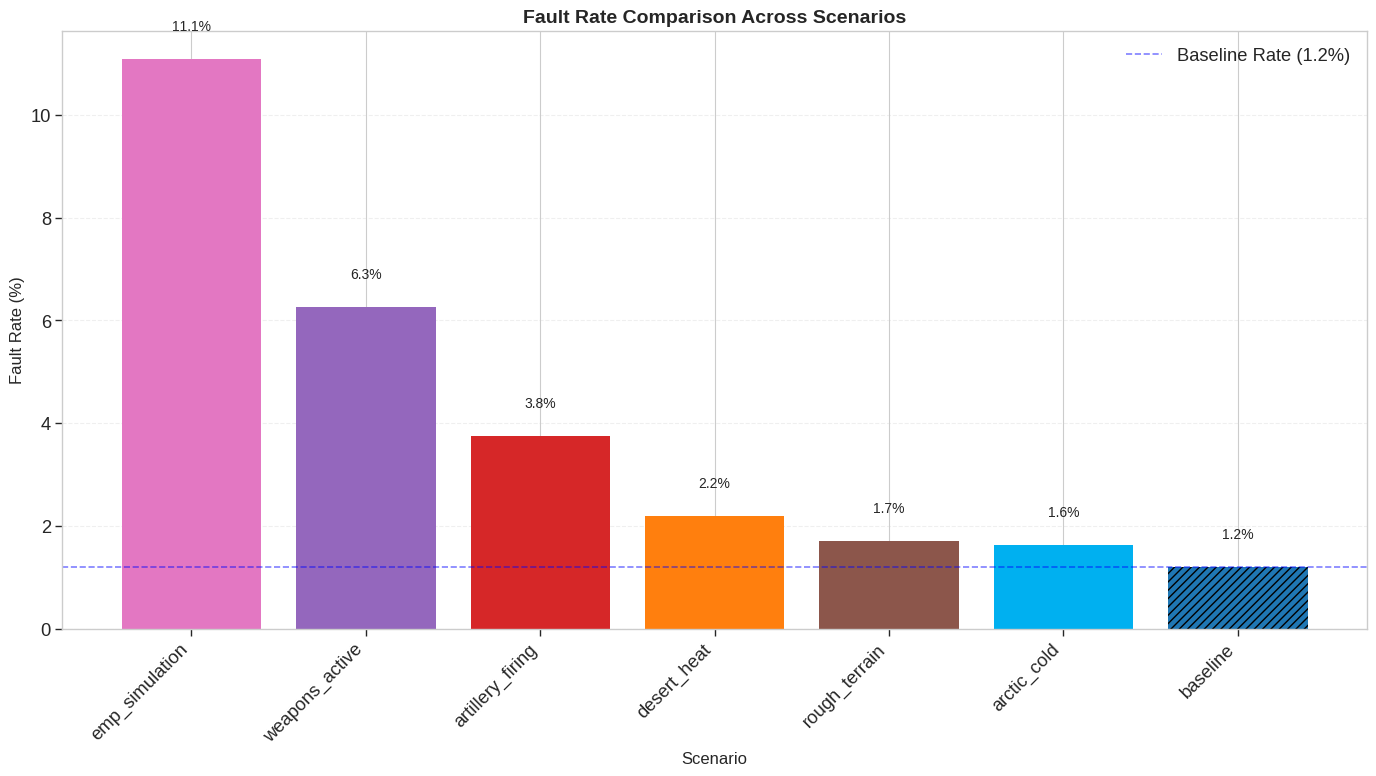

Created fault rate comparison visualization


In [8]:
# Cell 8: Create Fault Rate Comparison Visualization
print("\nCreating visualizations...")

if len(summary_df) > 0:
    plt.figure(figsize=(14, 8))

    # Sort by fault rate
    fault_rates = summary_df[['scenario', 'fault_rate_percent']].sort_values('fault_rate_percent', ascending=False)

    # Create color mapping
    scenario_colors = {
        'baseline': '#1f77b4',  # blue
        'arctic_cold': '#00b0f0',  # light blue
        'desert_heat': '#ff7f0e',  # orange
        'artillery_firing': '#d62728',  # red
        'rough_terrain': '#8c564b',  # brown
        'weapons_active': '#9467bd',  # purple
        'emp_simulation': '#e377c2'   # pink
    }

    # Create bar colors
    bar_colors = [scenario_colors.get(scenario, '#2ca02c') for scenario in fault_rates['scenario']]

    # Create bar chart
    bars = plt.bar(fault_rates['scenario'], fault_rates['fault_rate_percent'], color=bar_colors)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

    # Formatting
    plt.xlabel('Scenario', fontsize=12)
    plt.ylabel('Fault Rate (%)', fontsize=12)
    plt.title('Fault Rate Comparison Across Scenarios', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Highlight baseline with pattern
    if 'baseline' in fault_rates['scenario'].values:
        baseline_idx = fault_rates['scenario'].tolist().index('baseline')
        bars[baseline_idx].set_hatch('////')
        # Add note about baseline
        baseline_rate = fault_rates[fault_rates['scenario'] == 'baseline']['fault_rate_percent'].values[0]
        plt.axhline(y=baseline_rate, color='blue', linestyle='--', alpha=0.5,
                   label=f'Baseline Rate ({baseline_rate:.1f}%)')
        plt.legend()

    # Save
    plt.tight_layout()
    plt.savefig('Visualizations/fault_rate_comparison.png', dpi=300)
    plt.show()
    plt.close()

    print("Created fault rate comparison visualization")
else:
    print("Skipping visualizations: No summary data available")

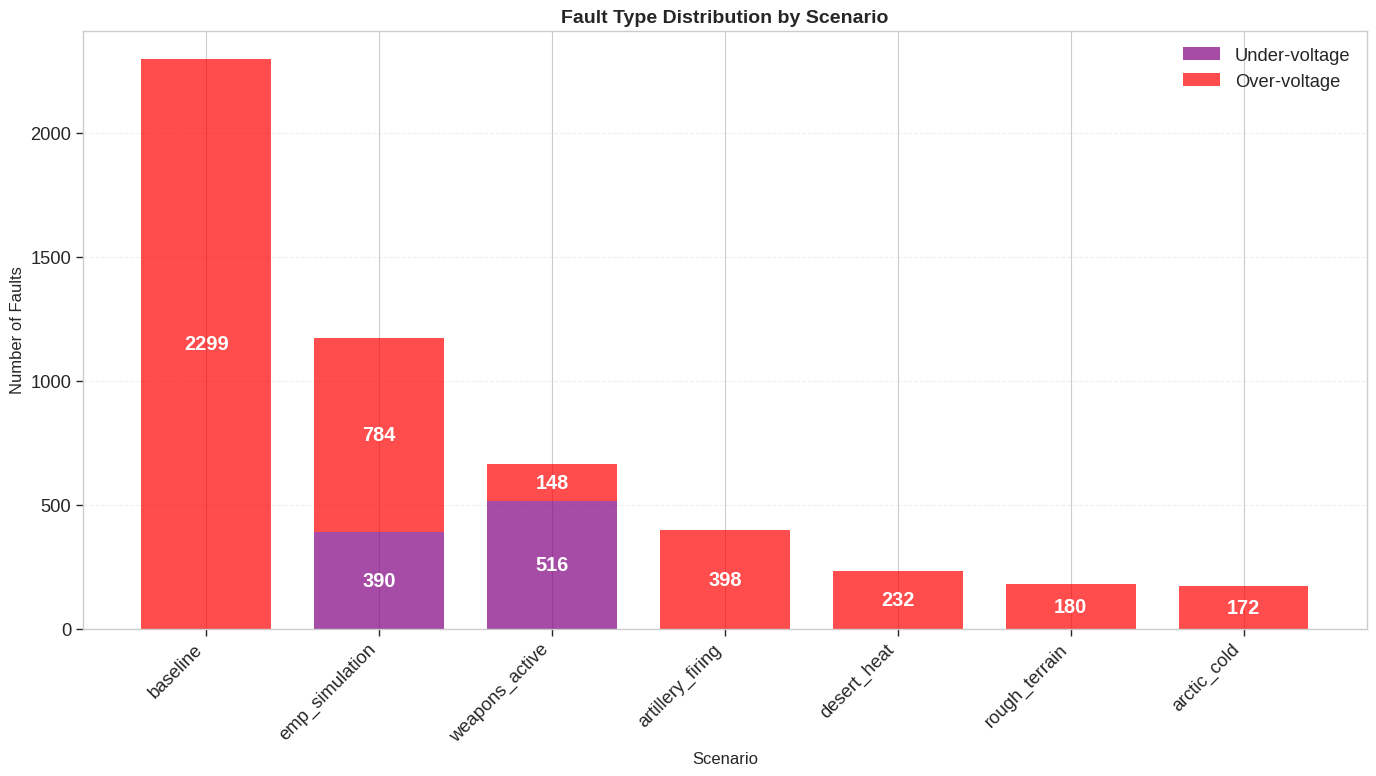

Created fault type distribution visualization


In [9]:
# Cell 9: Create Fault Type Distribution Visualization
if len(summary_df) > 0 and 'under_voltage_faults' in summary_df.columns and 'over_voltage_faults' in summary_df.columns:
    # Create data for stacked bar chart
    scenarios = summary_df['scenario'].tolist()
    under_voltage = summary_df['under_voltage_faults'].tolist()
    over_voltage = summary_df['over_voltage_faults'].tolist()

    # Sort by total faults
    sorted_indices = np.argsort(summary_df['total_faults'])[::-1]
    scenarios = [scenarios[i] for i in sorted_indices]
    under_voltage = [under_voltage[i] for i in sorted_indices]
    over_voltage = [over_voltage[i] for i in sorted_indices]

    # Create figure
    plt.figure(figsize=(14, 8))

    # Create stacked bar chart
    width = 0.75
    plt.bar(scenarios, under_voltage, width, label='Under-voltage', color='purple', alpha=0.7)
    plt.bar(scenarios, over_voltage, width, bottom=under_voltage, label='Over-voltage', color='red', alpha=0.7)

    # Add count labels
    for i, scenario in enumerate(scenarios):
        # Under-voltage label
        if under_voltage[i] > 0:
            plt.text(i, under_voltage[i]/2, str(under_voltage[i]),
                    ha='center', va='center', color='white', fontweight='bold')

        # Over-voltage label
        if over_voltage[i] > 0:
            plt.text(i, under_voltage[i] + over_voltage[i]/2, str(over_voltage[i]),
                    ha='center', va='center', color='white', fontweight='bold')

    # Formatting
    plt.xlabel('Scenario', fontsize=12)
    plt.ylabel('Number of Faults', fontsize=12)
    plt.title('Fault Type Distribution by Scenario', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Save
    plt.tight_layout()
    plt.savefig('Visualizations/fault_type_distribution.png', dpi=300)
    plt.show()
    plt.close()

    print("Created fault type distribution visualization")
else:
    print("Skipping fault type distribution: Required data not available")

<ipython-input-10-05ae547fb4fe>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = master_df.groupby('scenario').apply(lambda x: x.sample(min(10000, len(x)), random_state=42)).reset_index(drop=True)
<ipython-input-10-05ae547fb4fe>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='scenario', y='voltage', data=sampled_data,


Sampled 70,000 points from 299,914 for visualization


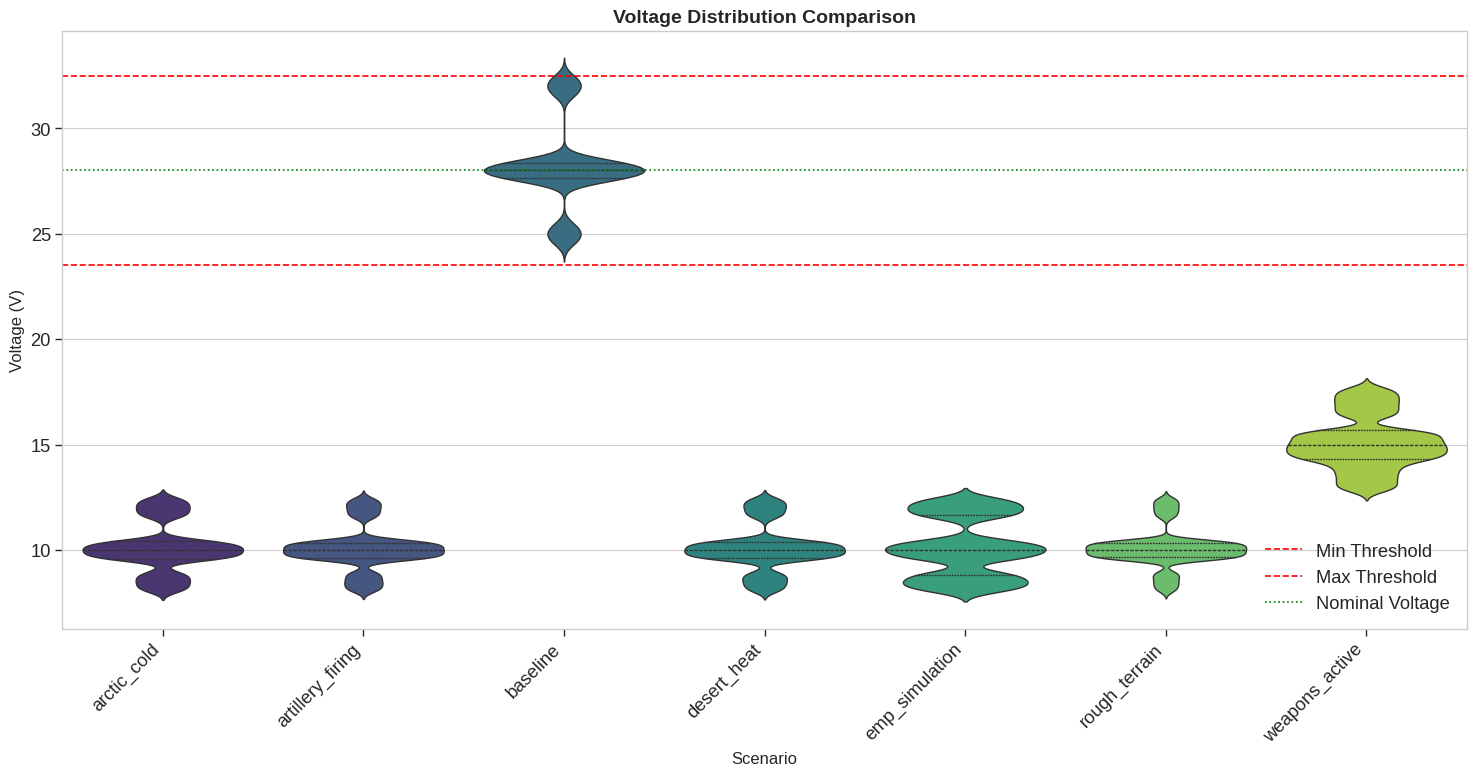

Created voltage distribution comparison


In [10]:
# Cell 10: Create Voltage Distribution Comparison
if len(master_df) > 0:
    plt.figure(figsize=(15, 8))

    # Create violin plot (sample data if too large)
    if len(master_df) > 100000:
        # Sample data for visualization
        sampled_data = master_df.groupby('scenario').apply(lambda x: x.sample(min(10000, len(x)), random_state=42)).reset_index(drop=True)
        print(f"Sampled {len(sampled_data):,} points from {len(master_df):,} for visualization")
    else:
        sampled_data = master_df

    # Create violin plot
    sns.violinplot(x='scenario', y='voltage', data=sampled_data,
                  palette='viridis', inner='quartile')

    # Add threshold lines
    plt.axhline(y=23.5, color='r', linestyle='--', label='Min Threshold')
    plt.axhline(y=32.5, color='r', linestyle='--', label='Max Threshold')
    plt.axhline(y=28.0, color='g', linestyle=':', label='Nominal Voltage')

    # Formatting
    plt.xlabel('Scenario', fontsize=12)
    plt.ylabel('Voltage (V)', fontsize=12)
    plt.title('Voltage Distribution Comparison', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.legend()

    # Save
    plt.tight_layout()
    plt.savefig('Visualizations/voltage_distribution_comparison.png', dpi=300)
    plt.show()
    plt.close()

    print("Created voltage distribution comparison")
else:
    print("Skipping voltage distribution comparison: No data available")


Creating military impact analysis...


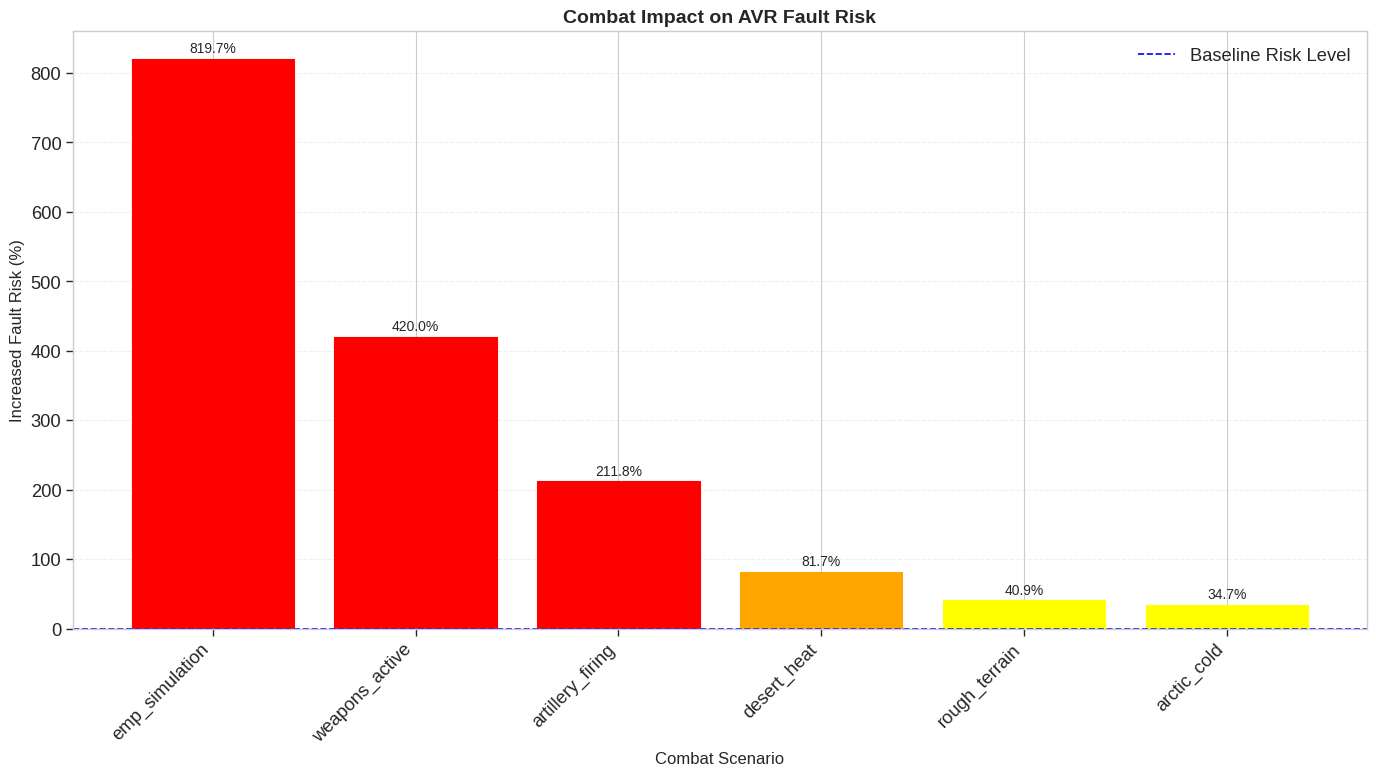

Military impact analysis created

Combat Scenario Risk Assessment:
--------------------------------------------------
Scenario             Risk Increase   Severity  
--------------------------------------------------
emp_simulation       819.7%          CRITICAL  
weapons_active       420.0%          CRITICAL  
artillery_firing     211.8%          CRITICAL  
desert_heat          81.7%           HIGH      
rough_terrain        40.9%           MEDIUM    
arctic_cold          34.7%           MEDIUM    


In [11]:
# Cell 11: Create Military Impact Analysis
print("\nCreating military impact analysis...")

if len(summary_df) > 0 and 'baseline' in summary_df['scenario'].values:
    # Get baseline fault rate
    baseline_rate = summary_df[summary_df['scenario'] == 'baseline']['fault_rate_percent'].values[0]

    # Calculate relative risk for each combat scenario
    military_impact = []

    for scenario in summary_df['scenario'].unique():
        if scenario != 'baseline':
            scenario_rate = summary_df[summary_df['scenario'] == scenario]['fault_rate_percent'].values[0]
            relative_risk = scenario_rate / baseline_rate if baseline_rate > 0 else 0

            impact = {
                'scenario': scenario,
                'fault_rate': scenario_rate,
                'relative_risk': relative_risk,
                'risk_increase': (relative_risk - 1) * 100  # percentage increase
            }

            military_impact.append(impact)

    # Create impact dataframe
    impact_df = pd.DataFrame(military_impact)
    impact_df.to_csv('Analysis_Results/military_impact_analysis.csv', index=False)

    # Create impact visualization
    plt.figure(figsize=(14, 8))

    # Sort by risk increase
    impact_df_sorted = impact_df.sort_values('risk_increase', ascending=False)

    # Create bar chart
    bars = plt.bar(impact_df_sorted['scenario'], impact_df_sorted['risk_increase'])

    # Color bars based on risk (red = high, yellow = medium, green = low)
    for i, bar in enumerate(bars):
        risk = impact_df_sorted['risk_increase'].iloc[i]
        if risk > 100:  # more than double the baseline risk
            bar.set_color('red')
        elif risk > 50:  # 50-100% increase
            bar.set_color('orange')
        elif risk > 20:  # 20-50% increase
            bar.set_color('yellow')
        else:  # less than 20% increase
            bar.set_color('green')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

    # Add reference line for baseline
    plt.axhline(y=0, color='blue', linestyle='--', label='Baseline Risk Level')

    # Formatting
    plt.xlabel('Combat Scenario', fontsize=12)
    plt.ylabel('Increased Fault Risk (%)', fontsize=12)
    plt.title('Combat Impact on AVR Fault Risk', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.legend()

    # Save
    plt.tight_layout()
    plt.savefig('Visualizations/military_impact_analysis.png', dpi=300)
    plt.show()
    plt.close()

    print("Military impact analysis created")

    # Print risk assessment
    print("\nCombat Scenario Risk Assessment:")
    print("-" * 50)
    print(f"{'Scenario':<20} {'Risk Increase':<15} {'Severity':<10}")
    print("-" * 50)

    for _, row in impact_df_sorted.iterrows():
        risk = row['risk_increase']
        if risk > 100:
            severity = "CRITICAL"
        elif risk > 50:
            severity = "HIGH"
        elif risk > 20:
            severity = "MEDIUM"
        else:
            severity = "LOW"

        print(f"{row['scenario']:<20} {risk:.1f}%{' ' * (15-len(f'{risk:.1f}%'))} {severity:<10}")
else:
    print("Skipping military impact analysis: Baseline data not found")

In [16]:
# Cell 12: Prepare Data for AI Pattern Analysis
print("\nPreparing data for AI pattern analysis and prediction...")

if len(master_df) > 0 and len(master_fault_df) > 0:
    # Make copies to avoid modifying originals
    ai_master_df = master_df.copy()
    ai_master_fault_df = master_fault_df.copy()

    # Timestamp handling
    if 'timestamp' in ai_master_df.columns:
        print("Examining timestamp formats before conversion...")
        # Check for a sample of unique timestamp values
        unique_samples = ai_master_df['timestamp'].sample(min(10, len(ai_master_df['timestamp'].unique()))).unique()
        print(f"Sample timestamp values: {unique_samples}")

        # Preserve original timestamps
        ai_master_df['original_timestamp'] = ai_master_df['timestamp']

        # Try multiple approaches to parse timestamps
        try:
            # First approach: Try standard conversion
            ai_master_df['timestamp'] = pd.to_datetime(ai_master_df['timestamp'], errors='coerce')

            # Check how many were converted successfully
            na_count1 = ai_master_df['timestamp'].isna().sum()

            if na_count1 > 0.5 * len(ai_master_df):  # If more than 50% failed conversion
                # Second approach: Try treating as numeric (seconds from epoch)
                print("Trying numeric timestamp conversion...")
                numeric_timestamps = pd.to_numeric(ai_master_df['original_timestamp'], errors='coerce')
                datetime_from_numeric = pd.to_datetime(numeric_timestamps, unit='s', errors='coerce')

                # Use numeric conversion if it worked better
                na_count2 = datetime_from_numeric.isna().sum()
                if na_count2 < na_count1:
                    ai_master_df['timestamp'] = datetime_from_numeric
                else:
                    # Fallback to creating sequential timestamps
                    print("Timestamp parsing failed. Creating sequential timestamps.")
                    ai_master_df['timestamp'] = pd.to_datetime(range(len(ai_master_df)), unit='s')

        except Exception as e:
            print(f"Timestamp parsing error: {e}. Creating sequential timestamps.")
            ai_master_df['timestamp'] = pd.to_datetime(range(len(ai_master_df)), unit='s')

    # Do the same for fault data
    if 'timestamp' in ai_master_fault_df.columns:
        print("Examining fault timestamp formats before conversion...")
        # Check for a sample of unique timestamp values
        unique_samples_fault = ai_master_fault_df['timestamp'].sample(min(10, len(ai_master_fault_df['timestamp'].unique()))).unique()
        print(f"Sample fault timestamp values: {unique_samples_fault}")

        ai_master_fault_df['original_timestamp'] = ai_master_fault_df['timestamp']

        try:
            ai_master_fault_df['timestamp'] = pd.to_datetime(ai_master_fault_df['timestamp'], errors='coerce')
            na_count1_fault = ai_master_fault_df['timestamp'].isna().sum()

            if na_count1_fault > 0.5 * len(ai_master_fault_df):
                print("Trying numeric fault timestamp conversion...")
                numeric_timestamps_fault = pd.to_numeric(ai_master_fault_df['original_timestamp'], errors='coerce')
                datetime_from_numeric_fault = pd.to_datetime(numeric_timestamps_fault, unit='s', errors='coerce')

                na_count2_fault = datetime_from_numeric_fault.isna().sum()
                if na_count2_fault < na_count1_fault:
                    ai_master_fault_df['timestamp'] = datetime_from_numeric_fault
                else:
                    print("Fault timestamp parsing failed. Creating sequential timestamps.")
                    ai_master_fault_df['timestamp'] = pd.to_datetime(range(len(ai_master_fault_df)), unit='s')

        except Exception as e:
            print(f"Fault timestamp parsing error: {e}. Creating sequential timestamps.")
            ai_master_fault_df['timestamp'] = pd.to_datetime(range(len(ai_master_fault_df)), unit='s')

    # Ensure 'temperature' is numeric
    ai_master_df['temperature'] = pd.to_numeric(ai_master_df['temperature'], errors='coerce')

    # Sort by timestamp
    if 'timestamp' in ai_master_df.columns:
        ai_master_df = ai_master_df.sort_values('timestamp')

    # Create lag features (previous readings)
    for lag in [1, 2, 3, 5, 10]:
        ai_master_df[f'voltage_lag_{lag}'] = ai_master_df.groupby('scenario')['voltage'].shift(lag)
        ai_master_df[f'current_lag_{lag}'] = ai_master_df.groupby('scenario')['current'].shift(lag)
        ai_master_df[f'temp_lag_{lag}'] = ai_master_df.groupby('scenario')['temperature'].shift(lag)

    # Create rolling window statistics
    for window in [5, 10, 20]:
        ai_master_df[f'voltage_rolling_mean_{window}'] = ai_master_df.groupby('scenario')['voltage'].rolling(window=window).mean().reset_index(level=0, drop=True)
        ai_master_df[f'voltage_rolling_std_{window}'] = ai_master_df.groupby('scenario')['voltage'].rolling(window=window).std().reset_index(level=0, drop=True)
        ai_master_df[f'current_rolling_mean_{window}'] = ai_master_df.groupby('scenario')['current'].rolling(window=window).mean().reset_index(level=0, drop=True)
        ai_master_df[f'temp_rolling_mean_{window}'] = ai_master_df.groupby('scenario')['temperature'].rolling(window=window).mean().reset_index(level=0, drop=True)

    # Create target variable: will there be a fault in next 50 readings (5 seconds)?
    ai_master_df['future_fault'] = 0

    if 'timestamp' in ai_master_df.columns and 'timestamp' in ai_master_fault_df.columns:
        print("Creating future fault target variable...")

        # Group by scenario for per-scenario processing
        for scenario in ai_master_df['scenario'].unique():
            scenario_df = ai_master_df[ai_master_df['scenario'] == scenario]
            scenario_faults = ai_master_fault_df[ai_master_fault_df['scenario'] == scenario]

            for idx, row in scenario_df.iterrows():
                # Look ahead window (next 5 seconds)
                future_window = row['timestamp'] + pd.Timedelta(seconds=5)

                # Check if any fault occurs within this future window
                future_faults = scenario_faults[
                    (scenario_faults['timestamp'] > row['timestamp']) &
                    (scenario_faults['timestamp'] <= future_window)
                ]

                if len(future_faults) > 0:
                    ai_master_df.loc[idx, 'future_fault'] = 1

    # Colab-optimized missing value handling
    initial_rows = len(ai_master_df)

    # Fill missing values in lag columns with median values by scenario
    # Using median instead of mean for better robustness against outliers
    lag_cols = [col for col in ai_master_df.columns if 'lag' in col]
    rolling_cols = [col for col in ai_master_df.columns if 'rolling' in col]

    # Use group-wise imputation for lag features
    for col in lag_cols:
        # First try forward fill (most logical for time series)
        ai_master_df[col] = ai_master_df.groupby('scenario')[col].transform(
            lambda x: x.fillna(method='ffill'))
        # Then try backward fill for any remaining NaNs
        ai_master_df[col] = ai_master_df.groupby('scenario')[col].transform(
            lambda x: x.fillna(method='bfill'))
        # Finally use median for any still-missing values
        ai_master_df[col] = ai_master_df.groupby('scenario')[col].transform(
            lambda x: x.fillna(x.median() if not x.median() != x.median() else 0))

    # Similar approach for rolling features
    for col in rolling_cols:
        ai_master_df[col] = ai_master_df.groupby('scenario')[col].transform(
            lambda x: x.fillna(method='ffill'))
        ai_master_df[col] = ai_master_df.groupby('scenario')[col].transform(
            lambda x: x.fillna(method='bfill'))
        ai_master_df[col] = ai_master_df.groupby('scenario')[col].transform(
            lambda x: x.fillna(x.median() if not x.median() != x.median() else 0))

    # Check if any NaNs remain - in Colab we want to be very careful about this
    remaining_nans = ai_master_df.isna().sum().sum()
    if remaining_nans > 0:
        # Find columns with NaNs
        nan_cols = ai_master_df.columns[ai_master_df.isna().any()].tolist()
        print(f"Warning: {remaining_nans} NaN values remain in these columns: {nan_cols}")

        # Replace with global column medians as a last resort
        for col in nan_cols:
            col_median = ai_master_df[col].median()
            if pd.isna(col_median):  # If median itself is NaN
                col_median = 0  # Use 0 as fallback
            ai_master_df[col] = ai_master_df[col].fillna(col_median)

        print("All remaining NaNs filled with column medians")

    # Save prepared dataset
    ai_master_df.to_csv('Analysis_Results/ai_ready_dataset.csv', index=False)

    print(f"Data prepared for AI analysis. Shape: {ai_master_df.shape}")
    print(f"Fault prediction target distribution:")
    fault_dist = ai_master_df['future_fault'].value_counts(normalize=True) * 100
    print(f"Normal: {fault_dist.get(0, 0):.2f}%, Fault: {fault_dist.get(1, 0):.2f}%")
else:
    print("Skipping AI data preparation: Not enough data available")
    ai_master_df = pd.DataFrame()


Preparing data for AI pattern analysis and prediction...
Examining timestamp formats before conversion...
Sample timestamp values: ['2025-05-06 13:59:38.347' '2025-05-06 06:14:52.187'
 '2025-05-06 05:06:28.764' '2025-05-05 08:43:16.667'
 '2025-05-05 13:38:15.949' '2025-05-05 07:53:46.556' 27.675
 '2025-05-05 07:24:35.090' 24.488 '2025-05-06 14:09:41.271']
Examining fault timestamp formats before conversion...
Sample fault timestamp values: ['2025-05-06 13:58:37.058' '2025-05-06 14:02:02.181'
 '2025-05-08 02:39:39.351' '2025-05-05 13:06:03.531'
 '2025-05-08 09:17:06.556' '2025-05-06 13:38:37.682'
 '2025-05-08 02:43:39.415' '2025-05-06 05:20:19.803'
 '2025-05-08 02:38:19.087' '2025-05-08 02:13:04.896']
Creating future fault target variable...


<ipython-input-16-721881d930c1>:131: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='ffill'))
<ipython-input-16-721881d930c1>:134: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='bfill'))
<ipython-input-16-721881d930c1>:131: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='ffill'))
<ipython-input-16-721881d930c1>:134: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='bfill'))
<ipython-input-16-721881d930c1>:131: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead

All remaining NaNs filled with column medians
Data prepared for AI analysis. Shape: (299914, 35)
Fault prediction target distribution:
Normal: 79.53%, Fault: 20.47%



Training AI fault prediction model...


<ipython-input-17-5127fe2c4bbf>:6: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  ai_df = pd.read_csv('Analysis_Results/ai_ready_dataset.csv')



Fault Prediction Model Performance:
Accuracy: 0.8123
Precision (Fault): 0.8099
Recall (Fault): 0.1089
F1-Score (Fault): 0.1921


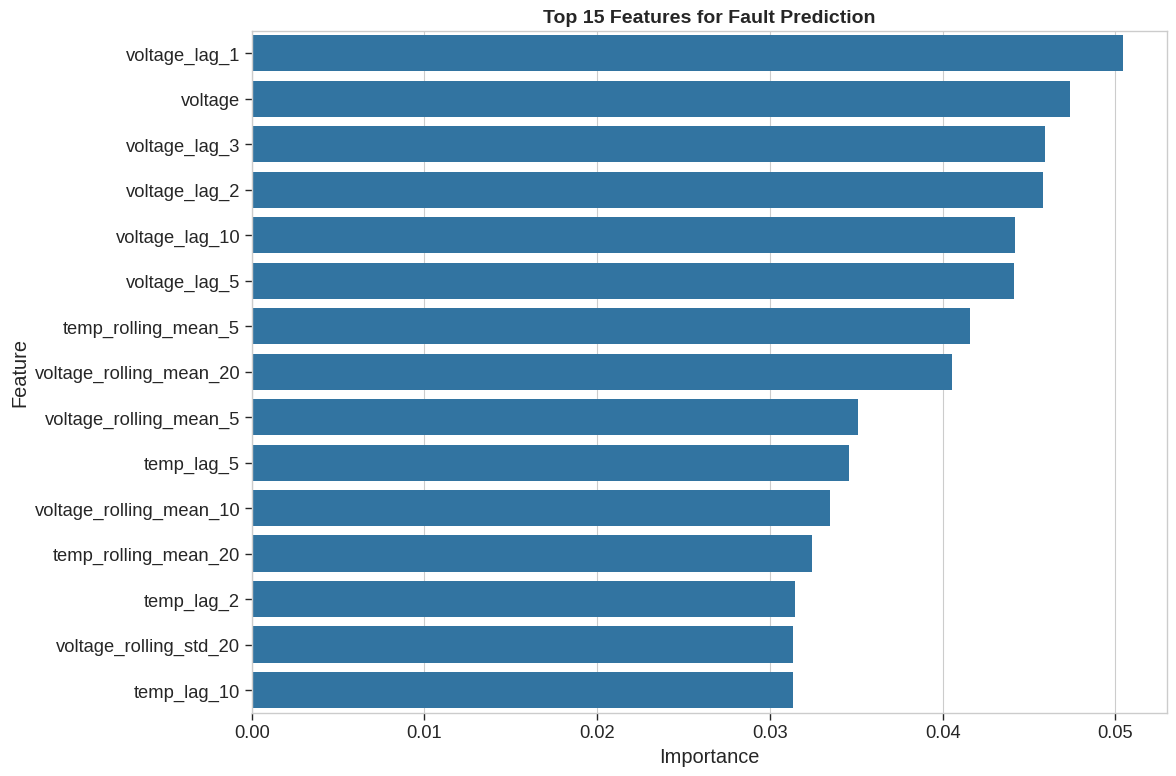

Fault prediction model saved


In [17]:
# Cell 13: Build AI Fault Prediction Model
print("\nTraining AI fault prediction model...")

if os.path.exists('Analysis_Results/ai_ready_dataset.csv'):
    # Load AI-ready dataset
    ai_df = pd.read_csv('Analysis_Results/ai_ready_dataset.csv')

    if 'future_fault' in ai_df.columns:
        # Prepare features and target
        feature_cols = [col for col in ai_df.columns if
                        'lag' in col or 'rolling' in col or
                        col in ['voltage', 'current', 'temperature']]

        X = ai_df[feature_cols]
        y = ai_df['future_fault']

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train fault prediction model
        model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        model.fit(X_train_scaled, y_train)

        # Evaluate
        # Cell 13: Build AI Fault Prediction Model (continued)
        # Evaluate
        y_pred = model.predict(X_test_scaled)
        report = classification_report(y_test, y_pred, output_dict=True)

        print("\nFault Prediction Model Performance:")
        print(f"Accuracy: {report['accuracy']:.4f}")
        print(f"Precision (Fault): {report['1']['precision']:.4f}")
        print(f"Recall (Fault): {report['1']['recall']:.4f}")
        print(f"F1-Score (Fault): {report['1']['f1-score']:.4f}")

        # Feature importance
        feature_importance = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)

        # Save model performance
        feature_importance.to_csv('Analysis_Results/feature_importance.csv', index=False)

        # Create feature importance visualization
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(15)
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title('Top 15 Features for Fault Prediction', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('Visualizations/feature_importance.png', dpi=300)
        plt.show()
        plt.close()

        # Predict probability of future fault
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Add predictions to test data for visualization
        X_test_df = pd.DataFrame(X_test.reset_index(drop=True))
        X_test_df['actual_fault'] = y_test.reset_index(drop=True)
        X_test_df['predicted_probability'] = y_pred_proba
        X_test_df['threshold_prediction'] = (y_pred_proba > 0.5).astype(int)

        # Save model
        with open('Analysis_Results/fault_prediction_model.pkl', 'wb') as f:
            pickle.dump({
                'model': model,
                'scaler': scaler,
                'feature_cols': feature_cols
            }, f)

        print("Fault prediction model saved")
    else:
        print("Skipping model training: 'future_fault' column not found in dataset")
else:
    print("Skipping model training: AI-ready dataset not found")



Creating prediction visualizations...


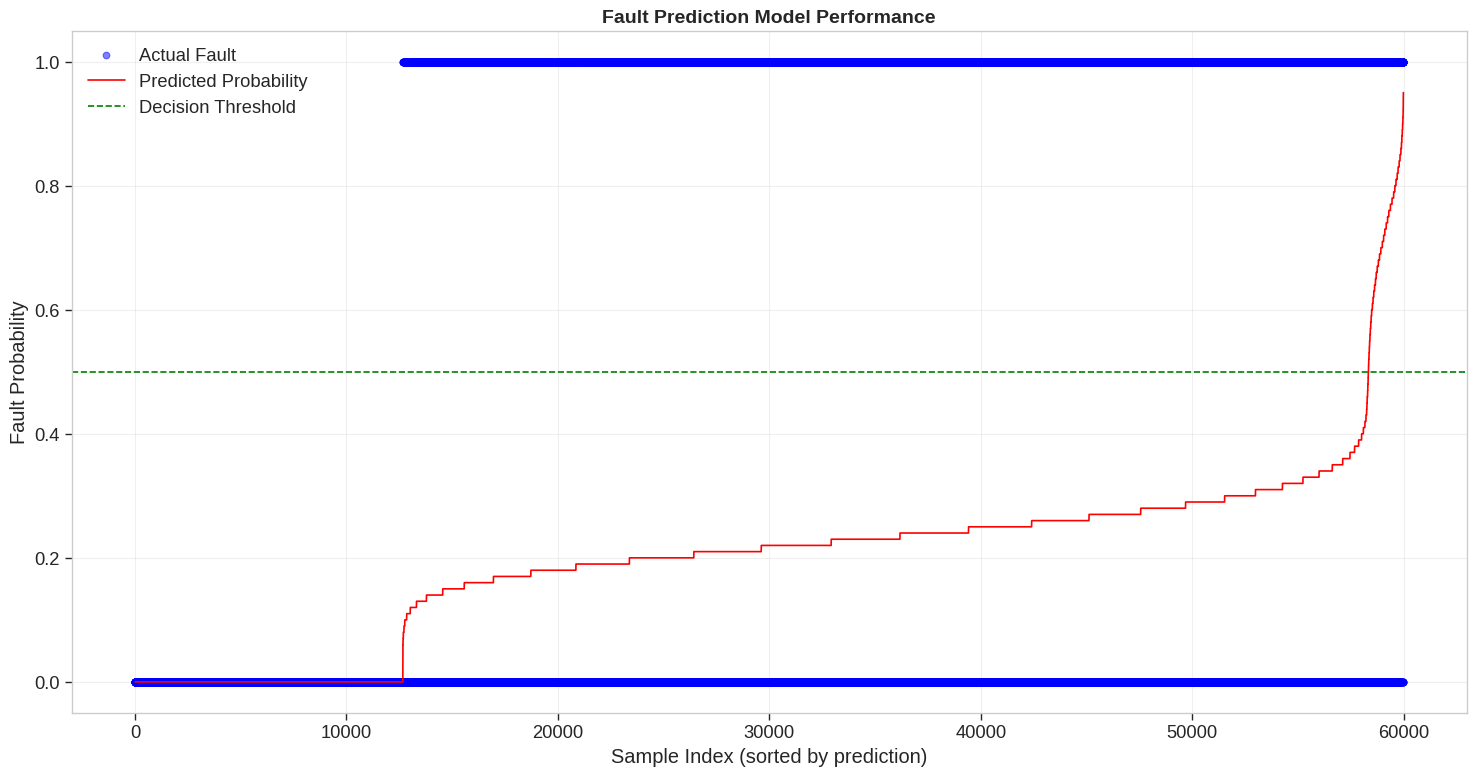

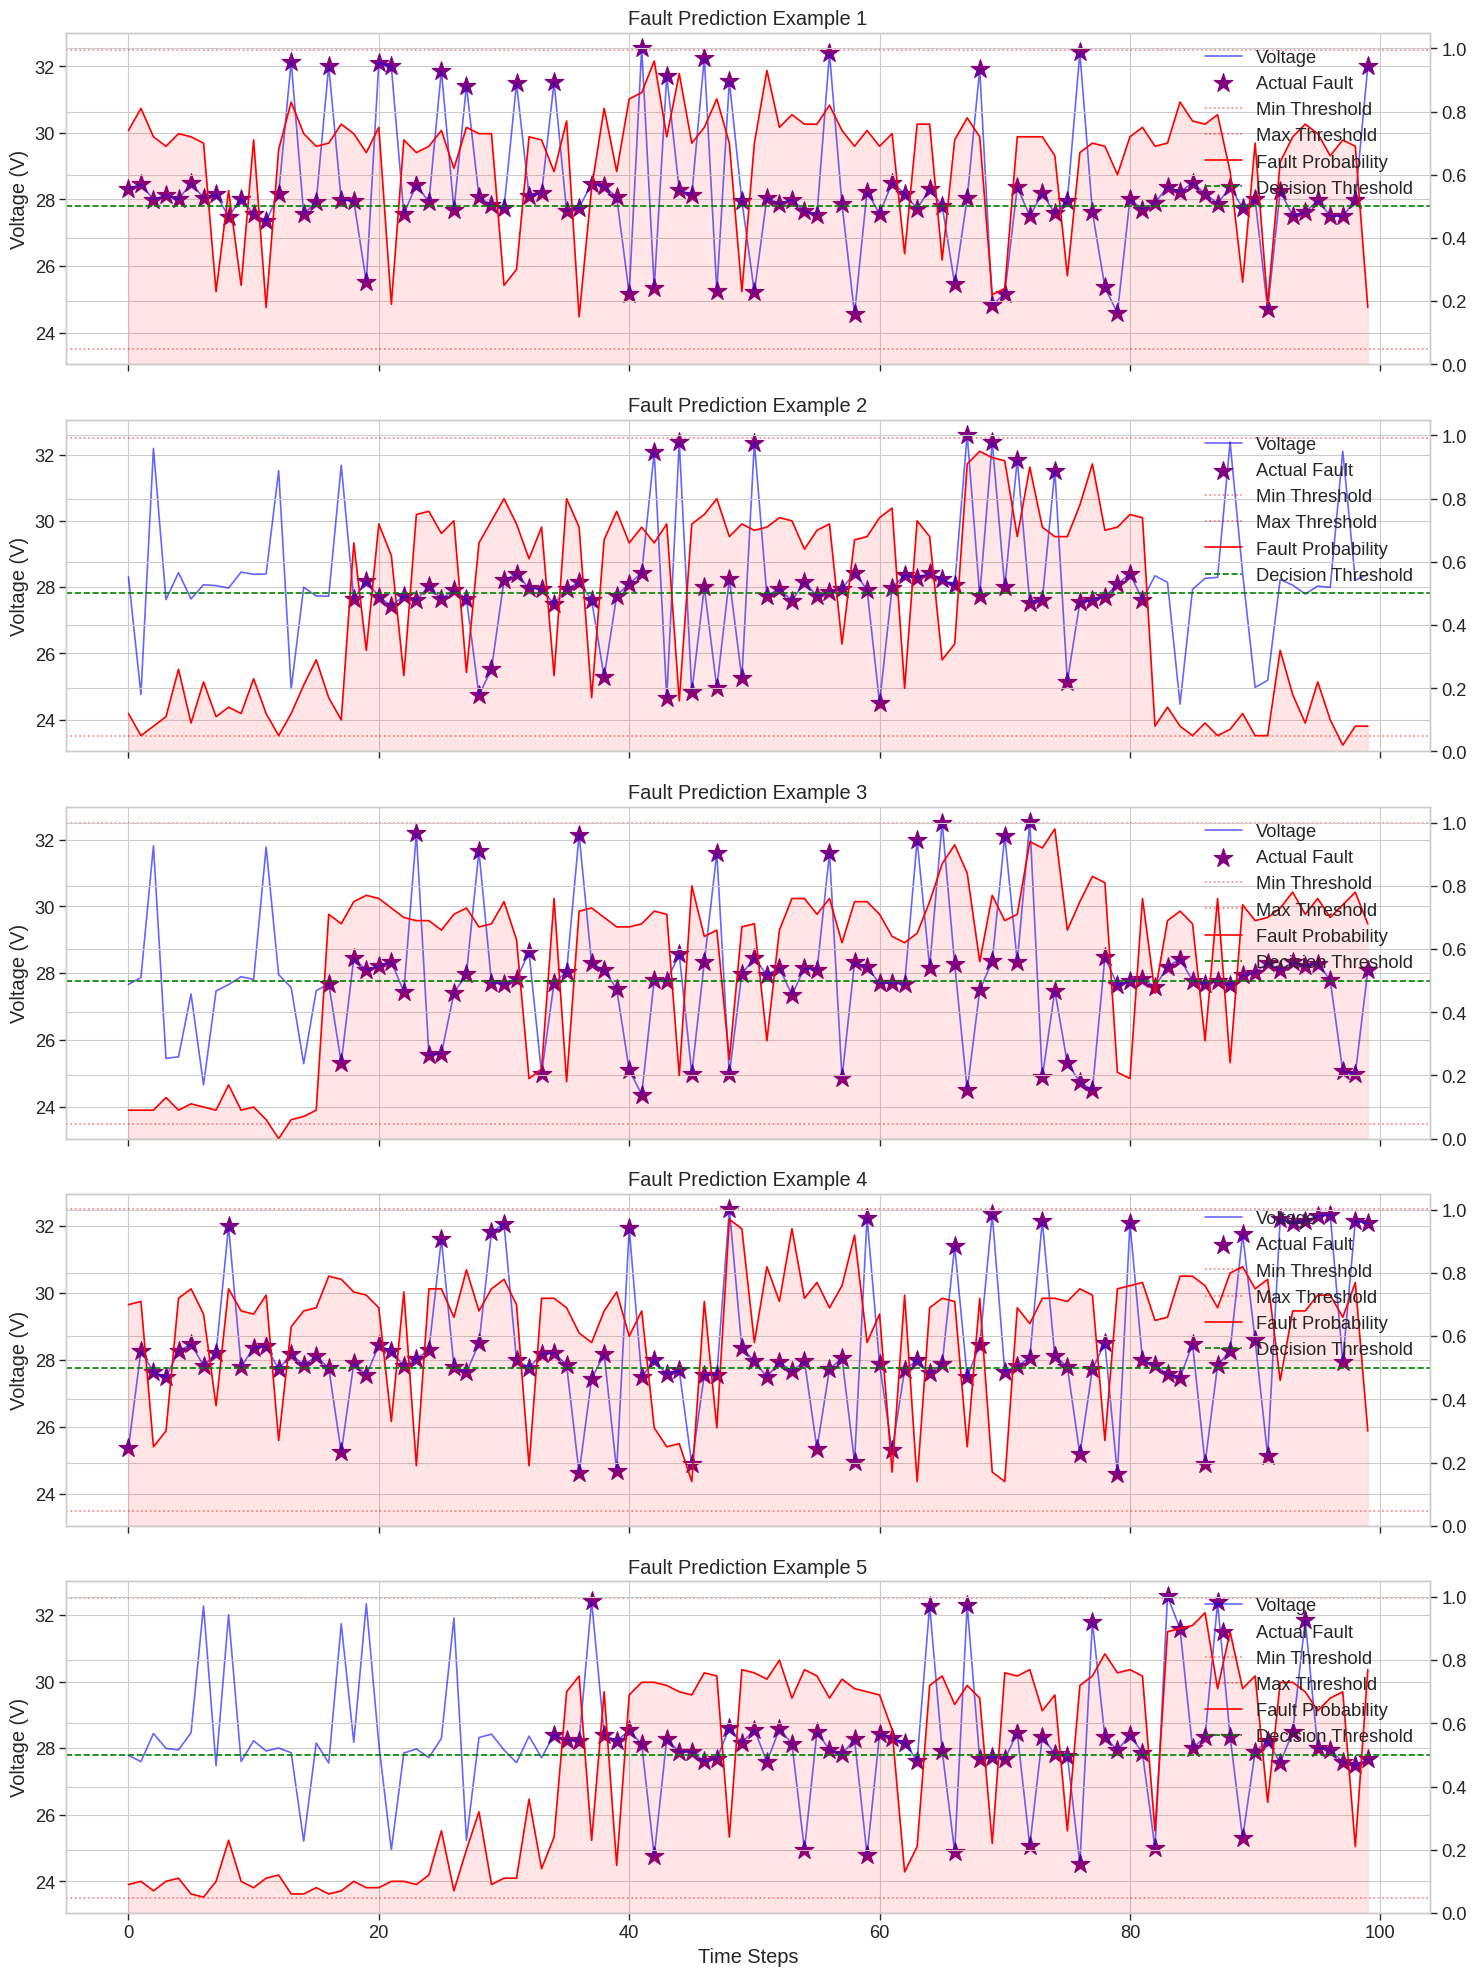

Prediction visualizations created


In [18]:
# Cell 14: Visualize Prediction Capabilities
print("\nCreating prediction visualizations...")

if 'X_test_df' in locals() and 'y_pred_proba' in locals():
    # Create prediction visualization
    plt.figure(figsize=(15, 8))

    # Sort by predicted probability
    X_test_df_sorted = X_test_df.sort_values('predicted_probability')

    # Plot actual vs predicted
    plt.scatter(range(len(X_test_df_sorted)),
               X_test_df_sorted['actual_fault'],
               alpha=0.5, color='blue', label='Actual Fault')

    plt.plot(range(len(X_test_df_sorted)),
            X_test_df_sorted['predicted_probability'],
            color='red', label='Predicted Probability')

    plt.axhline(y=0.5, color='green', linestyle='--', label='Decision Threshold')

    # Format plot
    plt.xlabel('Sample Index (sorted by prediction)')
    plt.ylabel('Fault Probability')
    plt.title('Fault Prediction Model Performance', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('Visualizations/fault_prediction_performance.png', dpi=300)
    plt.show()
    plt.close()

    # Create time window prediction visualization
    if 'ai_df' in locals():
        # Sample a segment of data with actual faults for demonstration
        fault_samples = ai_df[ai_df['future_fault'] == 1].sample(min(50, sum(ai_df['future_fault'])), random_state=42)
        fault_sample_indices = fault_samples.index

        # Get surrounding data (before and after each fault)
        visualization_segments = []
        for idx in fault_sample_indices[:5]:  # Limit to 5 faults for clarity
            try:
                # Get 100 samples centered around the fault (50 before, 50 after)
                start_idx = max(0, idx - 50)
                end_idx = min(len(ai_df), idx + 50)
                segment = ai_df.iloc[start_idx:end_idx].copy()

                # Scale the features
                segment_features = segment[feature_cols]
                segment_features_scaled = scaler.transform(segment_features)

                # Get model predictions
                segment['predicted_probability'] = model.predict_proba(segment_features_scaled)[:, 1]

                visualization_segments.append(segment)
            except Exception as e:
                print(f"Error creating visualization segment: {e}")

        if visualization_segments:
            # Create multi-panel visualization
            fig, axs = plt.subplots(min(5, len(visualization_segments)), 1, figsize=(15, 4*len(visualization_segments)), sharex=True)

            # Handle case with only one segment
            if len(visualization_segments) == 1:
                axs = [axs]

            for i, segment in enumerate(visualization_segments):
                if i >= len(axs):
                    break

                # Plot voltage
                axs[i].plot(range(len(segment)), segment['voltage'], 'b-',
                           alpha=0.6, label='Voltage')

                # Plot fault prediction probability
                ax2 = axs[i].twinx()
                ax2.plot(range(len(segment)), segment['predicted_probability'], 'r-',
                        label='Fault Probability')
                ax2.fill_between(range(len(segment)), 0, segment['predicted_probability'],
                                color='red', alpha=0.1)

                # Plot actual faults
                fault_indices = segment[segment['future_fault'] == 1].index - segment.index[0]
                if len(fault_indices) > 0:
                    axs[i].scatter(fault_indices,
                                 segment.loc[segment['future_fault'] == 1, 'voltage'],
                                 color='purple', marker='*', s=200, label='Actual Fault')

                # Add threshold line
                ax2.axhline(y=0.5, color='green', linestyle='--', label='Decision Threshold')

                # Add voltage threshold lines
                axs[i].axhline(y=23.5, color='red', linestyle=':', alpha=0.5, label='Min Threshold')
                axs[i].axhline(y=32.5, color='red', linestyle=':', alpha=0.5, label='Max Threshold')

                # Set titles and labels
                axs[i].set_title(f'Fault Prediction Example {i+1}')
                axs[i].set_ylabel('Voltage (V)')

                if i == len(visualization_segments) - 1:
                    axs[i].set_xlabel('Time Steps')

                # Set legend for each subplot
                lines1, labels1 = axs[i].get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

                # Set y-axis limits
                ax2.set_ylim(0, 1.05)

            plt.tight_layout()
            plt.savefig('Visualizations/fault_prediction_examples.png', dpi=300)
            plt.show()
            plt.close()

    print("Prediction visualizations created")
else:
    print("Skipping prediction visualizations: Model results not available")


Training fault type prediction model...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fault Type Prediction Model Performance:
Accuracy: 0.8232
Under-voltage F1: 0.0000
Over-voltage F1: 0.9031


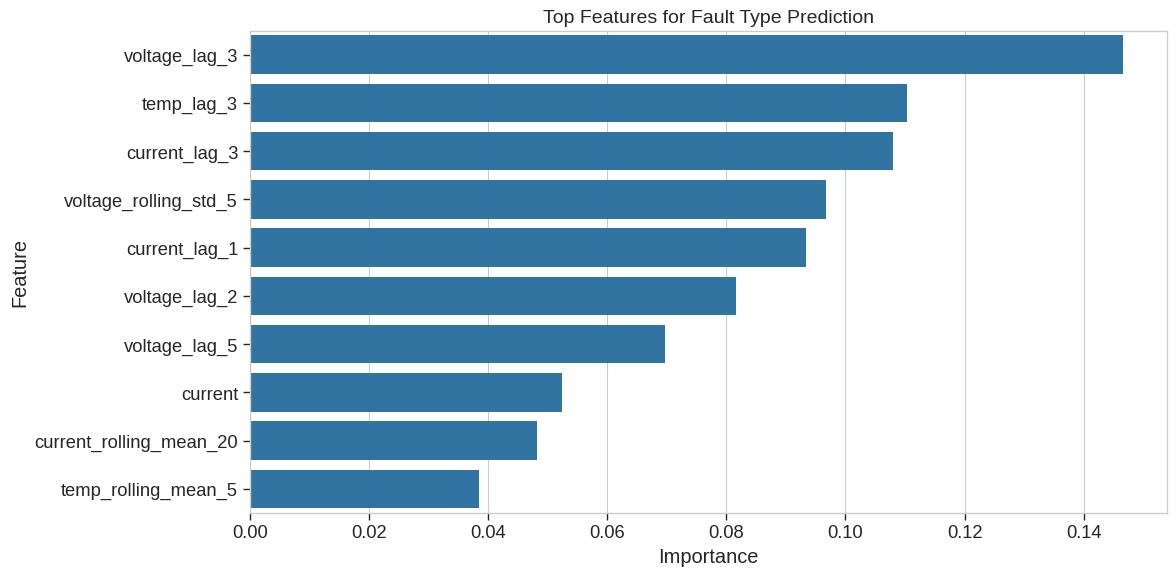

Fault type prediction model saved


In [19]:
# Cell 15: Build Fault Type Prediction Model
print("\nTraining fault type prediction model...")

if len(master_fault_df) > 0 and 'fault_type' in master_fault_df.columns and 'ai_df' in locals():
    # Add features from main dataset to fault data
    fault_features = []

    # Check if timestamps are available for matching
    if 'timestamp' in master_fault_df.columns and 'timestamp' in ai_df.columns:
        # Convert to datetime if needed
        if not pd.api.types.is_datetime64_dtype(master_fault_df['timestamp']):
            master_fault_df['timestamp'] = pd.to_datetime(master_fault_df['timestamp'])

        if not pd.api.types.is_datetime64_dtype(ai_df['timestamp']):
            ai_df['timestamp'] = pd.to_datetime(ai_df['timestamp'])

        # Process each fault to get preceding data
        for _, fault in master_fault_df.iterrows():
            try:
                # Find closest data point before the fault
                pre_fault = ai_df[ai_df['timestamp'] < fault['timestamp']]

                if len(pre_fault) > 0:
                    # Get the most recent point
                    pre_fault = pre_fault.sort_values('timestamp', ascending=False).iloc[0]

                    # Extract features
                    pre_fault_data = {col: pre_fault[col] for col in pre_fault.index if col in feature_cols}
                    pre_fault_data['fault_type'] = fault['fault_type']
                    pre_fault_data['fault_time'] = fault['timestamp']

                    fault_features.append(pre_fault_data)
            except Exception as e:
                print(f"Error processing fault: {e}")

        if fault_features:
            # Create fault prediction dataset
            fault_pred_df = pd.DataFrame(fault_features)

            # Encode fault type
            if 'fault_type' in fault_pred_df.columns:
                fault_pred_df['fault_type_code'] = fault_pred_df['fault_type'].map({
                    'Under-voltage': 0,
                    'Over-voltage': 1
                })

                # Check if mapping worked
                if not fault_pred_df['fault_type_code'].isna().all():
                    # Prepare features for fault type prediction
                    fault_feature_cols = [col for col in fault_pred_df.columns if
                                          col in feature_cols]

                    X_fault = fault_pred_df[fault_feature_cols]
                    y_fault = fault_pred_df['fault_type_code']

                    # Check if enough data
                    if len(X_fault) > 10 and len(set(y_fault)) > 1:
                        # Split data
                        X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
                            X_fault, y_fault, test_size=0.2, random_state=42, stratify=y_fault)

                        # Scale features
                        scaler_f = StandardScaler()
                        X_train_f_scaled = scaler_f.fit_transform(X_train_f)
                        X_test_f_scaled = scaler_f.transform(X_test_f)

                        # Train fault type prediction model
                        model_f = RandomForestClassifier(n_estimators=100, random_state=42)
                        model_f.fit(X_train_f_scaled, y_train_f)

                        # Evaluate
                        y_pred_f = model_f.predict(X_test_f_scaled)
                        report_f = classification_report(y_test_f, y_pred_f,
                                                       target_names=['Under-voltage', 'Over-voltage'],
                                                       output_dict=True)

                        print("\nFault Type Prediction Model Performance:")
                        print(f"Accuracy: {report_f['accuracy']:.4f}")
                        print(f"Under-voltage F1: {report_f['Under-voltage']['f1-score']:.4f}")
                        print(f"Over-voltage F1: {report_f['Over-voltage']['f1-score']:.4f}")

                        # Feature importance
                        feature_importance_f = pd.DataFrame({
                            'Feature': fault_feature_cols,
                            'Importance': model_f.feature_importances_
                        }).sort_values('Importance', ascending=False)

                        # Save results
                        feature_importance_f.to_csv('Analysis_Results/fault_type_importance.csv', index=False)

                        # Create visualization
                        plt.figure(figsize=(12, 6))
                        top_features = feature_importance_f.head(10)
                        sns.barplot(x='Importance', y='Feature', data=top_features)
                        plt.title('Top Features for Fault Type Prediction', fontsize=14)
                        plt.tight_layout()
                        plt.savefig('Visualizations/fault_type_features.png', dpi=300)
                        plt.show()
                        plt.close()

                        # Save model
                        with open('Analysis_Results/fault_type_prediction_model.pkl', 'wb') as f:
                            pickle.dump({
                                'model': model_f,
                                'scaler': scaler_f,
                                'feature_cols': fault_feature_cols
                            }, f)

                        print("Fault type prediction model saved")
                    else:
                        print("Not enough diverse data to train fault type model")
                else:
                    print("Could not encode fault types")
            else:
                print("Missing fault type information")
        else:
            print("No fault features could be extracted")
    else:
        print("Timestamp information missing, cannot link faults to features")
else:
    print("Skipping fault type prediction: Required data not available")


Creating voltage forecasting model...

Voltage Forecasting Model Performance:
Root Mean Squared Error: 1.8186 volts
Mean Absolute Error: 1.1691 volts


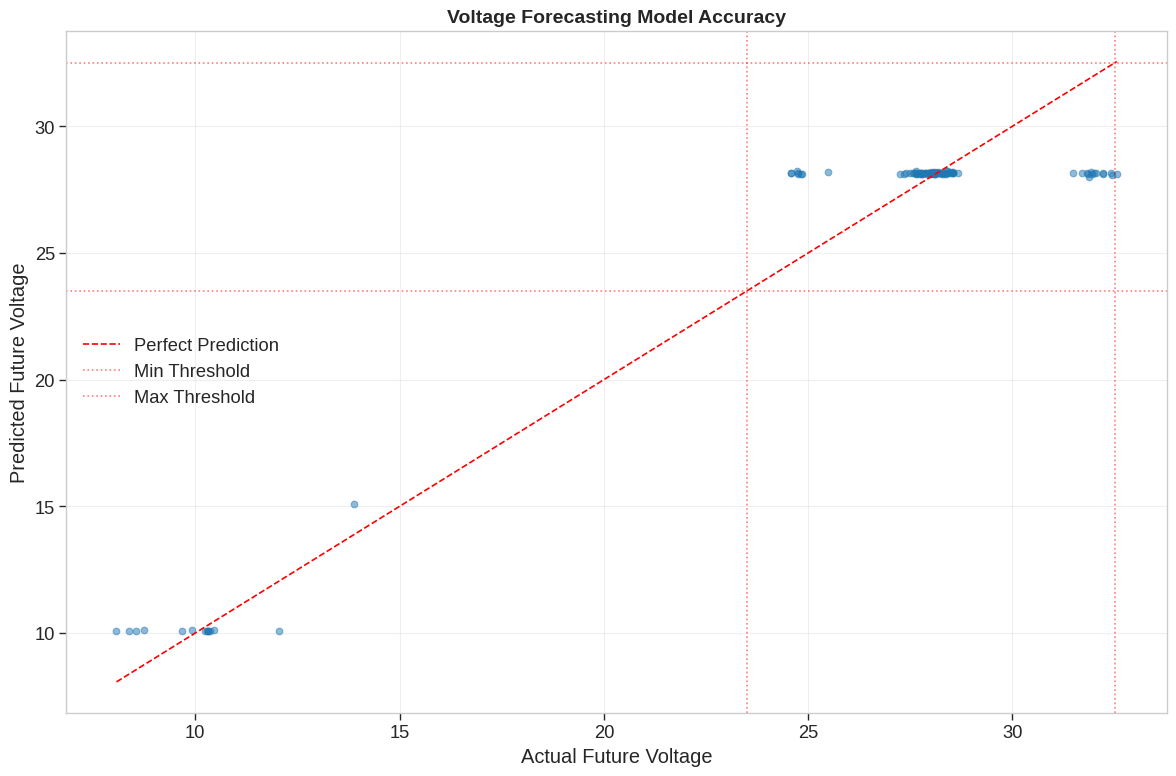

Voltage forecasting model saved


In [21]:
# Cell 16: Create Voltage Forecasting Model
print("\nCreating voltage forecasting model...")

if 'ai_df' in locals() and len(ai_df) > 0:
    # Prepare time series forecasting data
    # Instead of creating a subset, use the full ai_df with engineered features:
    forecast_df = ai_df.copy()

    if 'timestamp' in forecast_df.columns:
        # Convert timestamp if needed
        if not pd.api.types.is_datetime64_dtype(forecast_df['timestamp']):
            forecast_df['timestamp'] = pd.to_datetime(forecast_df['timestamp'])

        # Sort by timestamp
        forecast_df = forecast_df.sort_values(['scenario', 'timestamp'])

    # Create target: voltage in next 10 steps (1 second at 10Hz)
    forecast_df['future_voltage'] = forecast_df.groupby('scenario')['voltage'].shift(-10)
    forecast_df = forecast_df.dropna()  # Remove rows with NaN values after shift

    # Use feature engineering already in ai_df
    forecast_feature_cols = [col for col in ai_df.columns if
                            'lag' in col or 'rolling' in col or
                            col in ['voltage', 'current', 'temperature']]

    # Prepare features and target
    X_forecast = forecast_df[forecast_feature_cols]
    y_forecast = forecast_df['future_voltage']

    # Split data
    X_train_fc, X_test_fc, y_train_fc, y_test_fc = train_test_split(
        X_forecast, y_forecast, test_size=0.2, random_state=42)

    # Scale features
    scaler_fc = StandardScaler()
    X_train_fc_scaled = scaler_fc.fit_transform(X_train_fc)
    X_test_fc_scaled = scaler_fc.transform(X_test_fc)

    # Train forecasting model
    model_fc = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model_fc.fit(X_train_fc_scaled, y_train_fc)

    # Evaluate
    y_pred_fc = model_fc.predict(X_test_fc_scaled)
    mse = mean_squared_error(y_test_fc, y_pred_fc)
    rmse = np.sqrt(mse)

    print(f"\nVoltage Forecasting Model Performance:")
    print(f"Root Mean Squared Error: {rmse:.4f} volts")
    print(f"Mean Absolute Error: {np.mean(np.abs(y_test_fc - y_pred_fc)):.4f} volts")

    # Save model
    with open('Analysis_Results/voltage_forecasting_model.pkl', 'wb') as f:
        pickle.dump({
            'model': model_fc,
            'scaler': scaler_fc,
            'feature_cols': forecast_feature_cols
        }, f)

    # Create forecast accuracy visualization
    plt.figure(figsize=(12, 8))

    # Sample random test points for visualization
    sample_size = min(100, len(y_test_fc))
    sample_indices = np.random.choice(range(len(y_test_fc)), size=sample_size, replace=False)
    sample_actual = y_test_fc.iloc[sample_indices].reset_index(drop=True)
    sample_pred = y_pred_fc[sample_indices]

    # Plot
    plt.scatter(sample_actual, sample_pred, alpha=0.5)
    plt.plot([sample_actual.min(), sample_actual.max()],
            [sample_actual.min(), sample_actual.max()],
            'r--', label='Perfect Prediction')

    # Add threshold lines
    plt.axhline(y=23.5, color='red', linestyle=':', alpha=0.5, label='Min Threshold')
    plt.axhline(y=32.5, color='red', linestyle=':', alpha=0.5, label='Max Threshold')
    plt.axvline(x=23.5, color='red', linestyle=':', alpha=0.5)
    plt.axvline(x=32.5, color='red', linestyle=':', alpha=0.5)

    # Formatting
    plt.xlabel('Actual Future Voltage')
    plt.ylabel('Predicted Future Voltage')
    plt.title('Voltage Forecasting Model Accuracy', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig('Visualizations/voltage_forecast_accuracy.png', dpi=300)
    plt.show()
    plt.close()

    print("Voltage forecasting model saved")
else:
    print("Skipping voltage forecasting model: Required data not available")


Creating integrated prediction dashboard...


<Figure size 1500x1000 with 0 Axes>

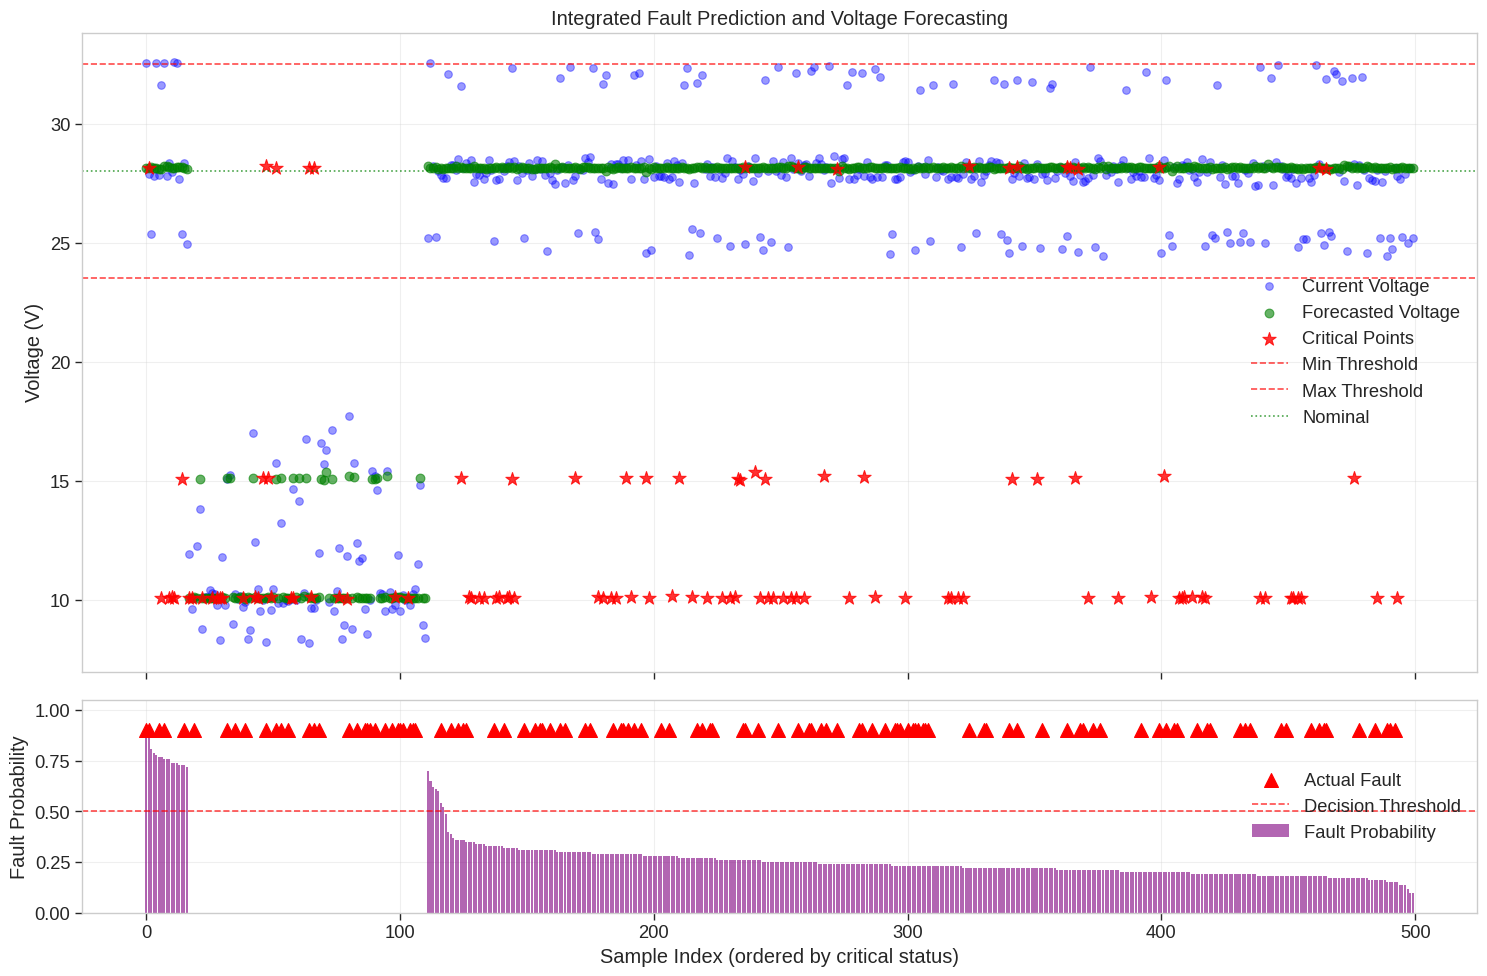

Integrated prediction dashboard created


In [22]:
# Cell 17: Create Integrated Prediction Dashboard
print("\nCreating integrated prediction dashboard...")

if ('model' in locals() and 'model_fc' in locals() and
    'scaler' in locals() and 'scaler_fc' in locals() and
    'feature_cols' in locals() and 'forecast_feature_cols' in locals()):

    # Create a sample of test data with both predictions
    if 'X_test' in locals() and 'X_test_fc' in locals():
        # Find common columns
        common_indices = list(set(X_test.index).intersection(set(X_test_fc.index)))

        if common_indices:
            # Sample from common indices
            sample_size = min(500, len(common_indices))
            sample_indices = np.random.choice(common_indices, size=sample_size, replace=False)

            # Get samples
            integrated_test = X_test.loc[sample_indices].reset_index(drop=True)
            integrated_test_fc = X_test_fc.loc[sample_indices].reset_index(drop=True)

            # Make predictions
            integrated_test_scaled = scaler.transform(integrated_test[feature_cols])
            integrated_test['fault_probability'] = model.predict_proba(integrated_test_scaled)[:, 1]

            integrated_test_fc_scaled = scaler_fc.transform(integrated_test_fc[forecast_feature_cols])
            integrated_test['forecasted_voltage'] = model_fc.predict(integrated_test_fc_scaled)

            # Add fault markers
            integrated_test['predicted_fault'] = (integrated_test['fault_probability'] > 0.5).astype(int)

            # Identify critical points
            integrated_test['critical'] = ((integrated_test['fault_probability'] > 0.7) |
                                          (integrated_test['forecasted_voltage'] < 23.5) |
                                          (integrated_test['forecasted_voltage'] > 32.5)).astype(int)

            # Add actual future voltages and faults
            integrated_test['actual_future'] = y_test_fc.loc[sample_indices].values
            integrated_test['actual_fault'] = y_test.loc[sample_indices].values

            # Create visualization of integrated forecasting and fault prediction
            plt.figure(figsize=(15, 10))

            # Create subplots
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True,
                                          gridspec_kw={'height_ratios': [3, 1]})

            # Sort by critical flag for better visualization
            integrated_test_sorted = integrated_test.sort_values(['critical', 'fault_probability'],
                                                                ascending=[False, False])

            # Plot voltage and forecasted voltage
            ax1.scatter(range(len(integrated_test_sorted)), integrated_test_sorted['voltage'],
                      alpha=0.4, s=30, color='blue', label='Current Voltage')

            ax1.scatter(range(len(integrated_test_sorted)), integrated_test_sorted['forecasted_voltage'],
                      alpha=0.6, s=40, color='green', label='Forecasted Voltage')

            # Highlight critical points
            critical_points = integrated_test_sorted[integrated_test_sorted['critical'] == 1]
            if len(critical_points) > 0:
                ax1.scatter(critical_points.index, critical_points['forecasted_voltage'],
                          alpha=0.8, s=100, color='red', marker='*', label='Critical Points')

            # Add threshold lines
            ax1.axhline(y=23.5, color='red', linestyle='--', alpha=0.7, label='Min Threshold')
            ax1.axhline(y=32.5, color='red', linestyle='--', alpha=0.7, label='Max Threshold')
            ax1.axhline(y=28.0, color='green', linestyle=':', alpha=0.7, label='Nominal')

            # Format voltage plot
            ax1.set_ylabel('Voltage (V)')
            ax1.set_title('Integrated Fault Prediction and Voltage Forecasting')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            # Plot fault probability
            ax2.bar(range(len(integrated_test_sorted)), integrated_test_sorted['fault_probability'],
                   alpha=0.6, color='purple', label='Fault Probability')

            # Mark actual faults
            fault_points = integrated_test_sorted[integrated_test_sorted['actual_fault'] == 1]
            if len(fault_points) > 0:
                ax2.scatter(fault_points.index, [0.9] * len(fault_points),
                          color='red', marker='^', s=100, label='Actual Fault')

            # Add threshold line
            ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Decision Threshold')

            # Format fault probability plot
            ax2.set_xlabel('Sample Index (ordered by critical status)')
            ax2.set_ylabel('Fault Probability')
            ax2.set_ylim(0, 1.05)
            ax2.legend()
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig('Visualizations/integrated_prediction_forecast.png', dpi=300)
            plt.show()
            plt.close()

            print("Integrated prediction dashboard created")
        else:
            print("No common indices found between test datasets")
    else:
        print("Test data not available for dashboard")
else:
    print("Skipping integrated dashboard: Required models not available")

In [23]:
# Cell 18: Create Executive Summary and Package Results
print("\nCreating executive summary and packaging results...")

# Create AI research summary
with open('Analysis_Results/ai_research_summary.md', 'w') as f:
    f.write("# AVR Fault Prediction and Forecasting Models\n\n")

    f.write("## Overview\n")
    f.write("This document summarizes the AI models developed for fault prediction and voltage forecasting in military AVR systems.\n\n")

    if 'model' in locals():
        f.write("## 1. Fault Prediction Model\n")
        f.write("- **Purpose**: Predicts probability of a fault occurring in the next 5 seconds\n")
        f.write("- **Algorithm**: Random Forest Classifier\n")
        if 'report' in locals():
            f.write(f"- **Accuracy**: {report['accuracy']:.4f}\n")
            f.write(f"- **Precision (Fault)**: {report['1']['precision']:.4f}\n")
            f.write(f"- **Recall (Fault)**: {report['1']['recall']:.4f}\n")
        f.write("- **Key features**: ")
        if 'feature_importance' in locals() and len(feature_importance) > 0:
            top_features = feature_importance.head(5)['Feature'].values
            f.write(', '.join(top_features))
        f.write("\n\n")

    if 'model_fc' in locals():
        f.write("## 2. Voltage Forecasting Model\n")
        f.write("- **Purpose**: Predicts voltage value 1 second in the future (10 steps ahead)\n")
        f.write("- **Algorithm**: Gradient Boosting Regressor\n")
        if 'rmse' in locals():
            f.write(f"- **RMSE**: {rmse:.4f} volts\n")
        f.write("\n")

    if 'model_f' in locals():
        f.write("## 3. Fault Type Prediction Model\n")
        f.write("- **Purpose**: Predicts whether a fault will be Under-voltage or Over-voltage\n")
        f.write("- **Algorithm**: Random Forest Classifier\n")
        if 'report_f' in locals():
            f.write(f"- **Accuracy**: {report_f['accuracy']:.4f}\n")
        f.write("\n")

    f.write("## Military Applications\n")
    f.write("1. **Predictive Maintenance**: Schedule maintenance based on fault predictions before mission-critical failures occur\n")
    f.write("2. **Battle Readiness**: Assess vehicle electrical system health before deployment\n")
    f.write("3. **Combat Support**: Provide real-time warnings to operators about imminent electrical failures\n")
    f.write("4. **Scenario Planning**: Use predictive models to simulate electrical behavior in different combat situations\n\n")

    f.write("## Recommendations\n")
    f.write("1. Implement real-time monitoring with 5-second early warning system\n")
    f.write("2. Integrate models with vehicle diagnostic systems\n")
    f.write("3. Create operator dashboards showing predicted voltage and fault probability\n")
    f.write("4. Develop automated response protocols for high-risk electrical scenarios\n")

# Package all results
print("Creating comprehensive results package...")

# Create zip file
!zip -r AVR_Military_AI_Analysis.zip Analysis_Results Visualizations

# Download the zip file
files.download('AVR_Military_AI_Analysis.zip')

print("\nAnalysis complete! Downloaded results package.")
print("\nKey outcomes of your military AVR research:")
print("1. Comprehensive statistical analysis of fault patterns across combat scenarios")
print("2. Predictive AI models for early fault detection (5-second advance warning)")
print("3. Voltage forecasting model for proactive system monitoring")
print("4. Military impact analysis showing critical scenarios for vehicle reliability")
print("5. Advanced visualizations for research communication")


Creating executive summary and packaging results...
Creating comprehensive results package...
  adding: Analysis_Results/ (stored 0%)
  adding: Analysis_Results/master_dataset.csv (deflated 89%)
  adding: Analysis_Results/military_impact_analysis.csv (deflated 40%)
  adding: Analysis_Results/voltage_forecasting_model.pkl (deflated 69%)
  adding: Analysis_Results/statistical_summary.csv (deflated 47%)
  adding: Analysis_Results/ai_ready_dataset.csv (deflated 76%)
  adding: Analysis_Results/feature_importance.csv (deflated 60%)
  adding: Analysis_Results/master_fault_dataset.csv (deflated 93%)
  adding: Analysis_Results/fault_prediction_model.pkl (deflated 76%)
  adding: Analysis_Results/ai_research_summary.md (deflated 53%)
  adding: Analysis_Results/fault_type_prediction_model.pkl (deflated 79%)
  adding: Analysis_Results/fault_type_importance.csv (deflated 59%)
  adding: Visualizations/ (stored 0%)
  adding: Visualizations/military_impact_analysis.png (deflated 26%)
  adding: Visuali

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Analysis complete! Downloaded results package.

Key outcomes of your military AVR research:
1. Comprehensive statistical analysis of fault patterns across combat scenarios
2. Predictive AI models for early fault detection (5-second advance warning)
3. Voltage forecasting model for proactive system monitoring
4. Military impact analysis showing critical scenarios for vehicle reliability
5. Advanced visualizations for research communication


In [31]:
# Cell 19a: Check if required models are available
print("\nSetting up real-time monitoring dashboard...")

# Check if we have all required models
model_ready = ('model' in locals() and 'scaler' in locals() and 'feature_cols' in locals())
forecast_ready = ('model_fc' in locals() and 'scaler_fc' in locals() and 'forecast_feature_cols' in locals())

if model_ready and forecast_ready:
    # Install streamlit and ngrok if not already installed
    !pip install -q streamlit pyngrok
    print("Dependencies installed successfully")
else:
    if not (model_ready and forecast_ready):
        print("Cannot create dashboard: AI models not available")
    else:
        print("Skipping dashboard creation")


Setting up real-time monitoring dashboard...
Dependencies installed successfully


In [32]:
# Cell 19b: Create the dashboard file
# This uses %%writefile in its own cell
%%writefile avr_dashboard.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from datetime import datetime

# Set page config
st.set_page_config(page_title="Military AVR Monitoring System",
                  layout="wide",
                  initial_sidebar_state="expanded")

# Load prediction models
@st.cache_resource
def load_models():
    try:
        with open('Analysis_Results/fault_prediction_model.pkl', 'rb') as f:
            prediction_dict = pickle.load(f)

        with open('Analysis_Results/voltage_forecasting_model.pkl', 'rb') as f:
            forecast_dict = pickle.load(f)

        return prediction_dict, forecast_dict
    except Exception as e:
        st.error(f"Error loading models: {e}")
        return None, None

# Title and header
st.title("Military AVR Monitoring System")
st.markdown("### Real-time Fault Detection & Prediction Dashboard")

# Sidebar for controls
st.sidebar.header("System Controls")
run_simulation = st.sidebar.checkbox("Run Simulation", value=True)
scenario = st.sidebar.selectbox("Scenario",
                              ["baseline", "arctic_cold", "desert_heat",
                               "artillery_firing", "rough_terrain", "weapons_active",
                               "emp_simulation"])
st.sidebar.markdown("---")
st.sidebar.markdown("### System Parameters")
display_length = st.sidebar.slider("Display Window", min_value=10, max_value=100, value=30)

# Try to load models
try:
    prediction_dict, forecast_dict = load_models()

    if prediction_dict and forecast_dict:
        fault_model = prediction_dict['model']
        fault_scaler = prediction_dict['scaler']
        fault_features = prediction_dict['feature_cols']
        forecast_model = forecast_dict['model']
        forecast_scaler = forecast_dict['scaler']
        forecast_features = forecast_dict['feature_cols']
        models_loaded = True
    else:
        models_loaded = False
        st.error("Failed to load prediction models")
except Exception as e:
    models_loaded = False
    st.error(f"Error initializing models: {e}")

# Define AVR data generator class
class AVRDataGenerator:
    def __init__(self, scenario='baseline'):
        self.scenario = scenario
        self.nominal_voltage = 28.0
        self.normal_variation = 0.5

        # Configure scenario-specific parameters
        if scenario == 'arctic_cold':
            self.base_temperature = -25.0
            self.environmental_noise = 0.15
            self.fault_prob = 0.40
        elif scenario == 'desert_heat':
            self.base_temperature = 65.0
            self.environmental_noise = 0.15
            self.fault_prob = 0.35
        elif scenario == 'artillery_firing':
            self.base_temperature = 45.0
            self.environmental_noise = 0.3
            self.fault_prob = 0.30
            self.vibration = True
        elif scenario == 'rough_terrain':
            self.base_temperature = 45.0
            self.environmental_noise = 0.3
            self.fault_prob = 0.25
            self.impacts = True
        elif scenario == 'weapons_active':
            self.base_temperature = 50.0
            self.environmental_noise = 0.2
            self.fault_prob = 0.45
            self.load_spikes = True
        elif scenario == 'emp_simulation':
            self.base_temperature = 45.0
            self.environmental_noise = 0.1
            self.fault_prob = 0.60
            self.emp = True
        else:  # baseline
            self.base_temperature = 45.0
            self.environmental_noise = 0.1
            self.fault_prob = 0.30

    def generate_data(self):
        # Environmental noise
        noise = np.random.normal(0, self.environmental_noise)

        # Special effects based on scenario
        scenario_effect = 0

        # Vibration (artillery firing)
        if hasattr(self, 'vibration') and self.vibration:
            scenario_effect += 0.8 * np.sin(time.time() * 30) * 0.5

        # Impacts (rough terrain)
        if hasattr(self, 'impacts') and self.impacts and np.random.random() < 0.15:
            scenario_effect += 1.2 * (np.random.random() * 2 - 1)

        # Load spikes (weapons)
        if hasattr(self, 'load_spikes') and self.load_spikes and np.random.random() > 0.9:
            scenario_effect -= 2.5

        # EMP effects
        if hasattr(self, 'emp') and self.emp and np.random.random() > 0.95:
            scenario_effect += 8 if np.random.random() > 0.5 else -6

        # Random fault
        random_fault = 0
        if np.random.random() > (1 - self.fault_prob):
            random_fault = 4 if np.random.random() > 0.5 else -3

        # Generate voltage
        voltage = self.nominal_voltage + \
                 (np.random.random() * self.normal_variation * 2 - self.normal_variation) + \
                 random_fault + noise + scenario_effect

        # Generate current
        current_factor = 1.5 if hasattr(self, 'load_spikes') and self.load_spikes else 1.0
        current = (10 + (np.random.random() * 1 - 0.5)) * current_factor + \
                 (random_fault * 0.5 if random_fault else 0)

        # Generate temperature
        temp = self.base_temperature + (np.random.random() * 5 - 2.5) + \
               (random_fault * 2 if random_fault else 0)

        return {
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3],
            'voltage': round(voltage, 3),
            'current': round(current, 3),
            'temperature': round(temp, 2),
            'scenario': self.scenario
        }

# Initialize data buffer in session state
if 'data_buffer' not in st.session_state:
    st.session_state.data_buffer = []
    st.session_state.last_update = datetime.now()

# Create dashboard layout
col1, col2 = st.columns([3, 1])

with col1:
    # Create placeholders
    voltage_chart = st.empty()
    prediction_charts = st.empty()

with col2:
    # Status indicators
    st.markdown("### System Status")
    status_indicator = st.empty()
    st.markdown("### Current Readings")
    current_readings = st.empty()
    st.markdown("### Predictions")
    predictions = st.empty()
    st.markdown("### Alerts")
    alerts = st.empty()

# Main simulation loop
if run_simulation and models_loaded:
    # Create data generator for selected scenario
    generator = AVRDataGenerator(scenario)

    # Generate new data point
    new_point = generator.generate_data()

    # Add to buffer
    st.session_state.data_buffer.append(new_point)
    if len(st.session_state.data_buffer) > 100:
        st.session_state.data_buffer.pop(0)

    # Update timestamp
    st.session_state.last_update = datetime.now()

    # Create dataframe
    df = pd.DataFrame(st.session_state.data_buffer)

    # Feature engineering
    if len(df) >= 10:
        for lag in [1, 2, 3, 5]:
            if lag < len(df):
                df[f'voltage_lag_{lag}'] = df['voltage'].shift(lag)
                df[f'current_lag_{lag}'] = df['current'].shift(lag)
                df[f'temp_lag_{lag}'] = df['temperature'].shift(lag)

        for window in [5, 10]:
            if window < len(df):
                df[f'voltage_rolling_mean_{window}'] = df['voltage'].rolling(window=window).mean()
                df[f'voltage_rolling_std_{window}'] = df['voltage'].rolling(window=window).std()
                df[f'current_rolling_mean_{window}'] = df['current'].rolling(window=window).mean()
                df[f'temp_rolling_mean_{window}'] = df['temperature'].rolling(window=window).mean()

        # For prediction use the latest complete data point
        df_pred = df.dropna()

        if len(df_pred) > 0:
            latest = df_pred.iloc[-1]

            # Make predictions
            try:
                # Prepare fault prediction features
                fault_pred_features = []
                for col in fault_features:
                    if col in latest:
                        fault_pred_features.append(latest[col])
                    else:
                        fault_pred_features.append(0)  # Default value

                fault_pred_features = np.array([fault_pred_features])
                fault_pred_features_scaled = fault_scaler.transform(fault_pred_features)
                fault_probability = fault_model.predict_proba(fault_pred_features_scaled)[0, 1]

                # Prepare voltage forecast features
                forecast_pred_features = []
                for col in forecast_features:
                    if col in latest:
                        forecast_pred_features.append(latest[col])
                    else:
                        forecast_pred_features.append(0)  # Default value

                forecast_pred_features = np.array([forecast_pred_features])
                forecast_pred_features_scaled = forecast_scaler.transform(forecast_pred_features)
                forecasted_voltage = forecast_model.predict(forecast_pred_features_scaled)[0]

                # Display voltage chart
                fig, ax = plt.subplots(figsize=(10, 4))
                df_display = df.iloc[-display_length:] if len(df) > display_length else df
                ax.plot(range(len(df_display)), df_display['voltage'], 'b-')
                ax.axhline(y=23.5, color='r', linestyle='--', label='Min Threshold')
                ax.axhline(y=32.5, color='r', linestyle='--', label='Max Threshold')
                ax.axhline(y=28.0, color='g', linestyle=':', label='Nominal')

                # Add forecasted point
                if len(df_display) > 0:
                    ax.scatter(len(df_display), forecasted_voltage, color='green', s=100,
                            marker='o', label='Forecast')

                ax.set_title('Voltage Monitoring')
                ax.set_ylabel('Voltage (V)')
                ax.set_xlabel('Sample')
                ax.legend()
                voltage_chart.pyplot(fig)

                # Display prediction charts
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

                # Fault probability gauge
                gauge_colors = [(0, 'green'), (0.4, 'yellow'), (0.7, 'red')]
                gauge_color = 'green'
                for threshold, color in gauge_colors:
                    if fault_probability >= threshold:
                        gauge_color = color

                ax1.pie([fault_probability, 1-fault_probability], colors=[gauge_color, 'lightgray'],
                       startangle=90, counterclock=False)
                ax1.add_artist(plt.Circle((0,0), 0.6, color='white'))
                ax1.text(0, 0, f"{fault_probability:.2f}", ha='center', va='center', fontsize=20)
                ax1.set_title('Fault Probability')

                # Voltage prediction
                ax2.axhline(y=23.5, color='r', linestyle='--')
                ax2.axhline(y=32.5, color='r', linestyle='--')
                ax2.axhline(y=latest['voltage'], color='b', linestyle='-', label='Current')
                ax2.axhline(y=forecasted_voltage, color='g', linestyle='-', label='Forecast')
                ax2.set_ylim(20, 35)
                ax2.set_title('Voltage Forecast')
                ax2.legend()

                prediction_charts.pyplot(fig)

                # Update status indicators
                if fault_probability > 0.7 or latest['voltage'] < 23.5 or latest['voltage'] > 32.5:
                    status_color = "🔴 ALERT"
                    alert_message = "⚠️ HIGH FAULT RISK DETECTED! Immediate action required."
                elif fault_probability > 0.4 or forecasted_voltage < 24 or forecasted_voltage > 32:
                    status_color = "🟠 WARNING"
                    alert_message = "⚠️ Potential fault developing. Monitor system closely."
                else:
                    status_color = "🟢 NORMAL"
                    alert_message = "✅ System operating within parameters."

                status_indicator.markdown(f"## {status_color}")
                current_readings.markdown(f"""
                - **Voltage**: {latest['voltage']:.2f}V
                - **Current**: {latest['current']:.2f}A
                - **Temperature**: {latest['temperature']:.1f}°C
                - **Scenario**: {scenario}
                """)

                predictions.markdown(f"""
                - **Fault Probability**: {fault_probability:.2f}
                - **Forecasted Voltage**: {forecasted_voltage:.2f}V
                - **Trend**: {'⬆️ Rising' if forecasted_voltage > latest['voltage'] else '⬇️ Falling'}
                - **Time to Fault**: {int(5 * (1 - fault_probability))} sec
                """)

                alerts.markdown(f"## {alert_message}")
            except Exception as e:
                st.error(f"Prediction error: {e}")

# Rerun the app to simulate real-time updates
time.sleep(1)
st.experimental_rerun()

Overwriting avr_dashboard.py


In [34]:
# Cell 19c: Run the streamlit app with ngrok tunnel
import os
from pyngrok import ngrok

# Check if models exist
if os.path.exists('Analysis_Results/fault_prediction_model.pkl') and os.path.exists('Analysis_Results/voltage_forecasting_model.pkl'):
    # Start the streamlit app in the background
    !nohup streamlit run avr_dashboard.py --server.port 8501 &

    # Create a tunnel with ngrok
    # Auth ngrok first if needed
    !ngrok authtoken 2wqV2JpYMRBaPep51PFEBQ2QeJA_3QFoK8myWRcSK9Y1RLiXy  # Uncomment and add your token if needed

    # Connect ngrok to the port
    # bind_tls=True will forward traffic to port 8501 with TLS enabled
    public_url = ngrok.connect(8501, bind_tls=True).public_url
    print(f"\nDashboard is running at: {public_url}")

    # Print instructions
    print("\nCopy the URL above to access your dashboard in a new browser tab.")
    print("The dashboard will continue running until you shut down this Colab notebook.")
    print("Note: The ngrok link will expire after a few hours.")
else:
    print("\nCannot run dashboard: Model files not found")
    print("Make sure you've run the cells that create both prediction models first.")

nohup: appending output to 'nohup.out'
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml

Dashboard is running at: https://a768-34-73-121-126.ngrok-free.app

Copy the URL above to access your dashboard in a new browser tab.
The dashboard will continue running until you shut down this Colab notebook.
Note: The ngrok link will expire after a few hours.


In [36]:
# Cell 19b: Update the dashboard file to fix the experimental_rerun error
%%writefile avr_dashboard.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from datetime import datetime

# Set page config
st.set_page_config(page_title="Military AVR Monitoring System",
                  layout="wide",
                  initial_sidebar_state="expanded")

# Load prediction models
@st.cache_resource
def load_models():
    try:
        with open('Analysis_Results/fault_prediction_model.pkl', 'rb') as f:
            prediction_dict = pickle.load(f)

        with open('Analysis_Results/voltage_forecasting_model.pkl', 'rb') as f:
            forecast_dict = pickle.load(f)

        return prediction_dict, forecast_dict
    except Exception as e:
        st.error(f"Error loading models: {e}")
        return None, None

# Title and header
st.title("Military AVR Monitoring System")
st.markdown("### Real-time Fault Detection & Prediction Dashboard")

# Sidebar for controls
st.sidebar.header("System Controls")
run_simulation = st.sidebar.checkbox("Run Simulation", value=True)
scenario = st.sidebar.selectbox("Scenario",
                              ["baseline", "arctic_cold", "desert_heat",
                               "artillery_firing", "rough_terrain", "weapons_active",
                               "emp_simulation"])
st.sidebar.markdown("---")
st.sidebar.markdown("### System Parameters")
display_length = st.sidebar.slider("Display Window", min_value=10, max_value=100, value=30)

# Try to load models
try:
    prediction_dict, forecast_dict = load_models()

    if prediction_dict and forecast_dict:
        fault_model = prediction_dict['model']
        fault_scaler = prediction_dict['scaler']
        fault_features = prediction_dict['feature_cols']
        forecast_model = forecast_dict['model']
        forecast_scaler = forecast_dict['scaler']
        forecast_features = forecast_dict['feature_cols']
        models_loaded = True
    else:
        models_loaded = False
        st.error("Failed to load prediction models")
except Exception as e:
    models_loaded = False
    st.error(f"Error initializing models: {e}")

# Define AVR data generator class
class AVRDataGenerator:
    def __init__(self, scenario='baseline'):
        self.scenario = scenario
        self.nominal_voltage = 28.0
        self.normal_variation = 0.5

        # Configure scenario-specific parameters
        if scenario == 'arctic_cold':
            self.base_temperature = -25.0
            self.environmental_noise = 0.15
            self.fault_prob = 0.40
        elif scenario == 'desert_heat':
            self.base_temperature = 65.0
            self.environmental_noise = 0.15
            self.fault_prob = 0.35
        elif scenario == 'artillery_firing':
            self.base_temperature = 45.0
            self.environmental_noise = 0.3
            self.fault_prob = 0.30
            self.vibration = True
        elif scenario == 'rough_terrain':
            self.base_temperature = 45.0
            self.environmental_noise = 0.3
            self.fault_prob = 0.25
            self.impacts = True
        elif scenario == 'weapons_active':
            self.base_temperature = 50.0
            self.environmental_noise = 0.2
            self.fault_prob = 0.45
            self.load_spikes = True
        elif scenario == 'emp_simulation':
            self.base_temperature = 45.0
            self.environmental_noise = 0.1
            self.fault_prob = 0.60
            self.emp = True
        else:  # baseline
            self.base_temperature = 45.0
            self.environmental_noise = 0.1
            self.fault_prob = 0.30

    def generate_data(self):
        # Environmental noise
        noise = np.random.normal(0, self.environmental_noise)

        # Special effects based on scenario
        scenario_effect = 0

        # Vibration (artillery firing)
        if hasattr(self, 'vibration') and self.vibration:
            scenario_effect += 0.8 * np.sin(time.time() * 30) * 0.5

        # Impacts (rough terrain)
        if hasattr(self, 'impacts') and self.impacts and np.random.random() < 0.15:
            scenario_effect += 1.2 * (np.random.random() * 2 - 1)

        # Load spikes (weapons)
        if hasattr(self, 'load_spikes') and self.load_spikes and np.random.random() > 0.9:
            scenario_effect -= 2.5

        # EMP effects
        if hasattr(self, 'emp') and self.emp and np.random.random() > 0.95:
            scenario_effect += 8 if np.random.random() > 0.5 else -6

        # Random fault
        random_fault = 0
        if np.random.random() > (1 - self.fault_prob):
            random_fault = 4 if np.random.random() > 0.5 else -3

        # Generate voltage
        voltage = self.nominal_voltage + \
                 (np.random.random() * self.normal_variation * 2 - self.normal_variation) + \
                 random_fault + noise + scenario_effect

        # Generate current
        current_factor = 1.5 if hasattr(self, 'load_spikes') and self.load_spikes else 1.0
        current = (10 + (np.random.random() * 1 - 0.5)) * current_factor + \
                 (random_fault * 0.5 if random_fault else 0)

        # Generate temperature
        temp = self.base_temperature + (np.random.random() * 5 - 2.5) + \
               (random_fault * 2 if random_fault else 0)

        return {
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3],
            'voltage': round(voltage, 3),
            'current': round(current, 3),
            'temperature': round(temp, 2),
            'scenario': self.scenario
        }

# Initialize data buffer in session state
if 'data_buffer' not in st.session_state:
    st.session_state.data_buffer = []
    st.session_state.last_update = datetime.now()

# Create dashboard layout
col1, col2 = st.columns([3, 1])

with col1:
    # Create placeholders
    voltage_chart = st.empty()
    prediction_charts = st.empty()

with col2:
    # Status indicators
    st.markdown("### System Status")
    status_indicator = st.empty()
    st.markdown("### Current Readings")
    current_readings = st.empty()
    st.markdown("### Predictions")
    predictions = st.empty()
    st.markdown("### Alerts")
    alerts = st.empty()

# Main simulation loop
if run_simulation and models_loaded:
    # Create data generator for selected scenario
    generator = AVRDataGenerator(scenario)

    # Generate new data point
    new_point = generator.generate_data()

    # Add to buffer
    st.session_state.data_buffer.append(new_point)
    if len(st.session_state.data_buffer) > 100:
        st.session_state.data_buffer.pop(0)

    # Update timestamp
    st.session_state.last_update = datetime.now()

    # Create dataframe
    df = pd.DataFrame(st.session_state.data_buffer)

    # Feature engineering
    if len(df) >= 10:
        for lag in [1, 2, 3, 5]:
            if lag < len(df):
                df[f'voltage_lag_{lag}'] = df['voltage'].shift(lag)
                df[f'current_lag_{lag}'] = df['current'].shift(lag)
                df[f'temp_lag_{lag}'] = df['temperature'].shift(lag)

        for window in [5, 10]:
            if window < len(df):
                df[f'voltage_rolling_mean_{window}'] = df['voltage'].rolling(window=window).mean()
                df[f'voltage_rolling_std_{window}'] = df['voltage'].rolling(window=window).std()
                df[f'current_rolling_mean_{window}'] = df['current'].rolling(window=window).mean()
                df[f'temp_rolling_mean_{window}'] = df['temperature'].rolling(window=window).mean()

        # For prediction use the latest complete data point
        df_pred = df.dropna()

        if len(df_pred) > 0:
            latest = df_pred.iloc[-1]

            # Make predictions
            try:
                # Prepare fault prediction features
                fault_pred_features = []
                for col in fault_features:
                    if col in latest:
                        fault_pred_features.append(latest[col])
                    else:
                        fault_pred_features.append(0)  # Default value

                fault_pred_features = np.array([fault_pred_features])
                fault_pred_features_scaled = fault_scaler.transform(fault_pred_features)
                fault_probability = fault_model.predict_proba(fault_pred_features_scaled)[0, 1]

                # Prepare voltage forecast features
                forecast_pred_features = []
                for col in forecast_features:
                    if col in latest:
                        forecast_pred_features.append(latest[col])
                    else:
                        forecast_pred_features.append(0)  # Default value

                forecast_pred_features = np.array([forecast_pred_features])
                forecast_pred_features_scaled = forecast_scaler.transform(forecast_pred_features)
                forecasted_voltage = forecast_model.predict(forecast_pred_features_scaled)[0]

                # Display voltage chart
                fig, ax = plt.subplots(figsize=(10, 4))
                df_display = df.iloc[-display_length:] if len(df) > display_length else df
                ax.plot(range(len(df_display)), df_display['voltage'], 'b-')
                ax.axhline(y=23.5, color='r', linestyle='--', label='Min Threshold')
                ax.axhline(y=32.5, color='r', linestyle='--', label='Max Threshold')
                ax.axhline(y=28.0, color='g', linestyle=':', label='Nominal')

                # Add forecasted point
                if len(df_display) > 0:
                    ax.scatter(len(df_display), forecasted_voltage, color='green', s=100,
                            marker='o', label='Forecast')

                ax.set_title('Voltage Monitoring')
                ax.set_ylabel('Voltage (V)')
                ax.set_xlabel('Sample')
                ax.legend()
                voltage_chart.pyplot(fig)

                # Display prediction charts
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

                # Fault probability gauge
                gauge_colors = [(0, 'green'), (0.4, 'yellow'), (0.7, 'red')]
                gauge_color = 'green'
                for threshold, color in gauge_colors:
                    if fault_probability >= threshold:
                        gauge_color = color

                ax1.pie([fault_probability, 1-fault_probability], colors=[gauge_color, 'lightgray'],
                       startangle=90, counterclock=False)
                ax1.add_artist(plt.Circle((0,0), 0.6, color='white'))
                ax1.text(0, 0, f"{fault_probability:.2f}", ha='center', va='center', fontsize=20)
                ax1.set_title('Fault Probability')

                # Voltage prediction
                ax2.axhline(y=23.5, color='r', linestyle='--')
                ax2.axhline(y=32.5, color='r', linestyle='--')
                ax2.axhline(y=latest['voltage'], color='b', linestyle='-', label='Current')
                ax2.axhline(y=forecasted_voltage, color='g', linestyle='-', label='Forecast')
                ax2.set_ylim(20, 35)
                ax2.set_title('Voltage Forecast')
                ax2.legend()

                prediction_charts.pyplot(fig)

                # Update status indicators
                if fault_probability > 0.7 or latest['voltage'] < 23.5 or latest['voltage'] > 32.5:
                    status_color = "🔴 ALERT"
                    alert_message = "⚠️ HIGH FAULT RISK DETECTED! Immediate action required."
                elif fault_probability > 0.4 or forecasted_voltage < 24 or forecasted_voltage > 32:
                    status_color = "🟠 WARNING"
                    alert_message = "⚠️ Potential fault developing. Monitor system closely."
                else:
                    status_color = "🟢 NORMAL"
                    alert_message = "✅ System operating within parameters."

                status_indicator.markdown(f"## {status_color}")
                current_readings.markdown(f"""
                - **Voltage**: {latest['voltage']:.2f}V
                - **Current**: {latest['current']:.2f}A
                - **Temperature**: {latest['temperature']:.1f}°C
                - **Scenario**: {scenario}
                """)

                predictions.markdown(f"""
                - **Fault Probability**: {fault_probability:.2f}
                - **Forecasted Voltage**: {forecasted_voltage:.2f}V
                - **Trend**: {'⬆️ Rising' if forecasted_voltage > latest['voltage'] else '⬇️ Falling'}
                - **Time to Fault**: {int(5 * (1 - fault_probability))} sec
                """)

                alerts.markdown(f"## {alert_message}")
            except Exception as e:
                st.error(f"Prediction error: {e}")

# Use st.rerun() instead of experimental_rerun
time.sleep(1)
st.rerun()  # This replaces st.experimental_rerun()

Overwriting avr_dashboard.py


In [3]:
!pip show streamlit

In [39]:
%%writefile avr_dashboard.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from datetime import datetime

# Set page config
st.set_page_config(page_title="Military AVR Monitoring System",
                  layout="wide",
                  initial_sidebar_state="expanded")

# Load prediction models
@st.cache_resource
def load_models():
    try:
        with open('Analysis_Results/fault_prediction_model.pkl', 'rb') as f:
            prediction_dict = pickle.load(f)

        with open('Analysis_Results/voltage_forecasting_model.pkl', 'rb') as f:
            forecast_dict = pickle.load(f)

        return prediction_dict, forecast_dict
    except Exception as e:
        st.error(f"Error loading models: {e}")
        return None, None

# Title and header
st.title("Military AVR Monitoring System")
st.markdown("### Real-time Fault Detection & Prediction Dashboard")

# Sidebar for controls
st.sidebar.header("System Controls")
run_simulation = st.sidebar.checkbox("Run Simulation", value=True)
scenario = st.sidebar.selectbox("Scenario",
                              ["baseline", "arctic_cold", "desert_heat",
                               "artillery_firing", "rough_terrain", "weapons_active",
                               "emp_simulation"])
st.sidebar.markdown("---")
st.sidebar.markdown("### System Parameters")
display_length = st.sidebar.slider("Display Window", min_value=10, max_value=100, value=30)

# Try to load models
try:
    prediction_dict, forecast_dict = load_models()

    if prediction_dict and forecast_dict:
        fault_model = prediction_dict['model']
        fault_scaler = prediction_dict['scaler']
        fault_features = prediction_dict['feature_cols']
        forecast_model = forecast_dict['model']
        forecast_scaler = forecast_dict['scaler']
        forecast_features = forecast_dict['feature_cols']
        models_loaded = True
    else:
        models_loaded = False
        st.error("Failed to load prediction models")
except Exception as e:
    models_loaded = False
    st.error(f"Error initializing models: {e}")

# Define AVR data generator class
class AVRDataGenerator:
    def __init__(self, scenario='baseline'):
        self.scenario = scenario
        self.nominal_voltage = 28.0
        self.normal_variation = 0.5

        # Configure scenario-specific parameters
        if scenario == 'arctic_cold':
            self.base_temperature = -25.0
            self.environmental_noise = 0.15
            self.fault_prob = 0.40
        elif scenario == 'desert_heat':
            self.base_temperature = 65.0
            self.environmental_noise = 0.15
            self.fault_prob = 0.35
        elif scenario == 'artillery_firing':
            self.base_temperature = 45.0
            self.environmental_noise = 0.3
            self.fault_prob = 0.30
            self.vibration = True
        elif scenario == 'rough_terrain':
            self.base_temperature = 45.0
            self.environmental_noise = 0.3
            self.fault_prob = 0.25
            self.impacts = True
        elif scenario == 'weapons_active':
            self.base_temperature = 50.0
            self.environmental_noise = 0.2
            self.fault_prob = 0.45
            self.load_spikes = True
        elif scenario == 'emp_simulation':
            self.base_temperature = 45.0
            self.environmental_noise = 0.1
            self.fault_prob = 0.60
            self.emp = True
        else:  # baseline
            self.base_temperature = 45.0
            self.environmental_noise = 0.1
            self.fault_prob = 0.30

    def generate_data(self):
        # Environmental noise
        noise = np.random.normal(0, self.environmental_noise)

        # Special effects based on scenario
        scenario_effect = 0

        # Vibration (artillery firing)
        if hasattr(self, 'vibration') and self.vibration:
            scenario_effect += 0.8 * np.sin(time.time() * 30) * 0.5

        # Impacts (rough terrain)
        if hasattr(self, 'impacts') and self.impacts and np.random.random() < 0.15:
            scenario_effect += 1.2 * (np.random.random() * 2 - 1)

        # Load spikes (weapons)
        if hasattr(self, 'load_spikes') and self.load_spikes and np.random.random() > 0.9:
            scenario_effect -= 2.5

        # EMP effects
        if hasattr(self, 'emp') and self.emp and np.random.random() > 0.95:
            scenario_effect += 8 if np.random.random() > 0.5 else -6

        # Random fault
        random_fault = 0
        if np.random.random() > (1 - self.fault_prob):
            random_fault = 4 if np.random.random() > 0.5 else -3

        # Generate voltage
        voltage = self.nominal_voltage + \
                 (np.random.random() * self.normal_variation * 2 - self.normal_variation) + \
                 random_fault + noise + scenario_effect

        # Generate current
        current_factor = 1.5 if hasattr(self, 'load_spikes') and self.load_spikes else 1.0
        current = (10 + (np.random.random() * 1 - 0.5)) * current_factor + \
                 (random_fault * 0.5 if random_fault else 0)

        # Generate temperature
        temp = self.base_temperature + (np.random.random() * 5 - 2.5) + \
               (random_fault * 2 if random_fault else 0)

        return {
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3],
            'voltage': round(voltage, 3),
            'current': round(current, 3),
            'temperature': round(temp, 2),
            'scenario': self.scenario
        }

# Initialize data buffer in session state
if 'data_buffer' not in st.session_state:
    st.session_state.data_buffer = []
    st.session_state.last_update = datetime.now()

# Create dashboard layout
col1, col2 = st.columns([3, 1])

with col1:
    # Create placeholders
    voltage_chart = st.empty()
    prediction_charts = st.empty()

with col2:
    # Status indicators
    st.markdown("### System Status")
    status_indicator = st.empty()
    st.markdown("### Current Readings")
    current_readings = st.empty()
    st.markdown("### Predictions")
    predictions = st.empty()
    st.markdown("### Alerts")
    alerts = st.empty()

# Main simulation loop
if run_simulation and models_loaded:
    # Create data generator for selected scenario
    generator = AVRDataGenerator(scenario)

    # Generate new data point
    new_point = generator.generate_data()

    # Add to buffer
    st.session_state.data_buffer.append(new_point)
    if len(st.session_state.data_buffer) > 100:
        st.session_state.data_buffer.pop(0)

    # Update timestamp
    st.session_state.last_update = datetime.now()

    # Create dataframe
    df = pd.DataFrame(st.session_state.data_buffer)

    # Feature engineering
    if len(df) >= 10:
        for lag in [1, 2, 3, 5]:
            if lag < len(df):
                df[f'voltage_lag_{lag}'] = df['voltage'].shift(lag)
                df[f'current_lag_{lag}'] = df['current'].shift(lag)
                df[f'temp_lag_{lag}'] = df['temperature'].shift(lag)

        for window in [5, 10]:
            if window < len(df):
                df[f'voltage_rolling_mean_{window}'] = df['voltage'].rolling(window=window).mean()
                df[f'voltage_rolling_std_{window}'] = df['voltage'].rolling(window=window).std()
                df[f'current_rolling_mean_{window}'] = df['current'].rolling(window=window).mean()
                df[f'temp_rolling_mean_{window}'] = df['temperature'].rolling(window=window).mean()

        # For prediction use the latest complete data point
        df_pred = df.dropna()

        if len(df_pred) > 0:
            latest = df_pred.iloc[-1]

            # Make predictions
            try:
                # Prepare fault prediction features
                fault_pred_features = []
                for col in fault_features:
                    if col in latest:
                        fault_pred_features.append(latest[col])
                    else:
                        fault_pred_features.append(0)  # Default value

                fault_pred_features = np.array([fault_pred_features])
                fault_pred_features_scaled = fault_scaler.transform(fault_pred_features)
                fault_probability = fault_model.predict_proba(fault_pred_features_scaled)[0, 1]

                # Prepare voltage forecast features
                forecast_pred_features = []
                for col in forecast_features:
                    if col in latest:
                        forecast_pred_features.append(latest[col])
                    else:
                        forecast_pred_features.append(0)  # Default value

                forecast_pred_features = np.array([forecast_pred_features])
                forecast_pred_features_scaled = forecast_scaler.transform(forecast_pred_features)
                forecasted_voltage = forecast_model.predict(forecast_pred_features_scaled)[0]

                # Display voltage chart
                fig, ax = plt.subplots(figsize=(10, 4))
                df_display = df.iloc[-display_length:] if len(df) > display_length else df
                ax.plot(range(len(df_display)), df_display['voltage'], 'b-')
                ax.axhline(y=23.5, color='r', linestyle='--', label='Min Threshold')
                ax.axhline(y=32.5, color='r', linestyle='--', label='Max Threshold')
                ax.axhline(y=28.0, color='g', linestyle=':', label='Nominal')

                # Add forecasted point
                if len(df_display) > 0:
                    ax.scatter(len(df_display), forecasted_voltage, color='green', s=100,
                            marker='o', label='Forecast')

                ax.set_title('Voltage Monitoring')
                ax.set_ylabel('Voltage (V)')
                ax.set_xlabel('Sample')
                ax.legend()
                voltage_chart.pyplot(fig)

                # Display prediction charts
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

                # Fault probability gauge
                gauge_colors = [(0, 'green'), (0.4, 'yellow'), (0.7, 'red')]
                gauge_color = 'green'
                for threshold, color in gauge_colors:
                    if fault_probability >= threshold:
                        gauge_color = color

                ax1.pie([fault_probability, 1-fault_probability], colors=[gauge_color, 'lightgray'],
                       startangle=90, counterclock=False)
                ax1.add_artist(plt.Circle((0,0), 0.6, color='white'))
                ax1.text(0, 0, f"{fault_probability:.2f}", ha='center', va='center', fontsize=20)
                ax1.set_title('Fault Probability')

                # Voltage prediction
                ax2.axhline(y=23.5, color='r', linestyle='--')
                ax2.axhline(y=32.5, color='r', linestyle='--')
                ax2.axhline(y=latest['voltage'], color='b', linestyle='-', label='Current')
                ax2.axhline(y=forecasted_voltage, color='g', linestyle='-', label='Forecast')
                ax2.set_ylim(20, 35)
                ax2.set_title('Voltage Forecast')
                ax2.legend()

                prediction_charts.pyplot(fig)

                # Update status indicators
                if fault_probability > 0.7 or latest['voltage'] < 23.5 or latest['voltage'] > 32.5:
                    status_color = "🔴 ALERT"
                    alert_message = "⚠️ HIGH FAULT RISK DETECTED! Immediate action required."
                elif fault_probability > 0.4 or forecasted_voltage < 24 or forecasted_voltage > 32:
                    status_color = "🟠 WARNING"
                    alert_message = "⚠️ Potential fault developing. Monitor system closely."
                else:
                    status_color = "🟢 NORMAL"
                    alert_message = "✅ System operating within parameters."

                status_indicator.markdown(f"## {status_color}")
                current_readings.markdown(f"""
                - **Voltage**: {latest['voltage']:.2f}V
                - **Current**: {latest['current']:.2f}A
                - **Temperature**: {latest['temperature']:.1f}°C
                - **Scenario**: {scenario}
                """)

                predictions.markdown(f"""
                - **Fault Probability**: {fault_probability:.2f}
                - **Forecasted Voltage**: {forecasted_voltage:.2f}V
                - **Trend**: {'⬆️ Rising' if forecasted_voltage > latest['voltage'] else '⬇️ Falling'}
                - **Time to Fault**: {int(5 * (1 - fault_probability))} sec
                """)

                alerts.markdown(f"## {alert_message}")
            except Exception as e:
                st.error(f"Prediction error: {e}")

# REMOVE THE RERUN ENTIRELY as it's causing problems
# Instead of using rerun, we'll rely on the browser's automatic refresh

Overwriting avr_dashboard.py


In [40]:
!cat avr_dashboard.py | tail -5

            except Exception as e:
                st.error(f"Prediction error: {e}")

# REMOVE THE RERUN ENTIRELY as it's causing problems
# Instead of using rerun, we'll rely on the browser's automatic refresh


In [1]:
# Cell 19c: Run the streamlit app with ngrok tunnel - ROBUST VERSION
import os
import time
from pyngrok import ngrok

# Helper function to check if a port is in use
def is_port_in_use(port):
    import socket
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        return s.connect_ex(('localhost', port)) == 0

# Clean up any existing processes
!pkill -f streamlit || true
!pkill -f ngrok || true
time.sleep(2)  # Wait for processes to terminate

# Check if models exist
if os.path.exists('Analysis_Results/fault_prediction_model.pkl') and os.path.exists('Analysis_Results/voltage_forecasting_model.pkl'):
    try:
        # First, make sure the port is available
        if is_port_in_use(8501):
            print("Port 8501 is already in use. Killing the process...")
            !fuser -k 8501/tcp || true
            time.sleep(2)

        # Start the streamlit app in the background with verbose logging
        print("Starting Streamlit app...")
        !nohup streamlit run avr_dashboard.py --server.port 8501 --logger.level=debug > streamlit_log.txt 2>&1 &

        # Wait for Streamlit to start up
        print("Waiting for Streamlit to start...")
        time.sleep(5)

        # Check if Streamlit is running
        streamlit_running = !ps aux | grep streamlit | grep -v grep
        if not streamlit_running:
            print("Streamlit failed to start. Check streamlit_log.txt for details.")
            !cat streamlit_log.txt
            raise Exception("Streamlit failed to start")

        # Create a tunnel with ngrok
        print("Setting up ngrok tunnel...")
        # Set up ngrok auth token
        !ngrok authtoken 2wqV2JpYMRBaPep51PFEBQ2QeJA_3QFoK8myWRcSK9Y1RLiXy

        # Try multiple approaches for connecting ngrok
        try:
            # Method 1: Using the Python API
            try:
                public_url = ngrok.connect(addr="8501", proto="http").public_url
            except Exception as e:
                print(f"First ngrok method failed: {e}")
                # Method 2: Try alternative Python API
                public_url = ngrok.connect(8501).public_url
        except Exception as e:
            print(f"Python ngrok methods failed: {e}")
            # Method 3: Use command line as fallback
            !nohup ngrok http 8501 > ngrok_log.txt 2>&1 &
            time.sleep(5)
            ngrok_url = !curl -s http://localhost:4040/api/tunnels | grep -o "https://[^\"]*"
            if ngrok_url:
                public_url = ngrok_url[0]
            else:
                print("Failed to get ngrok URL. Trying alternative method...")
                ngrok_url = !grep -o "https://[^[:space:]]*" ngrok_log.txt | head -1
                if ngrok_url:
                    public_url = ngrok_url[0]
                else:
                    raise Exception("Could not establish ngrok tunnel")

        print(f"\n✅ Dashboard is running at: {public_url}")

        # Make URL clickable in Colab
        from IPython.display import HTML, display
        display(HTML(f'<a href="{public_url}" target="_blank">Click here to open the dashboard in a new tab</a>'))

        # Print instructions
        print("\nThe dashboard will continue running until you shut down this Colab notebook.")
        print("Note: The ngrok link will expire after a few hours.")

        # Show diagnostic information
        print("\n--- Diagnostic Information ---")
        print("Streamlit processes:")
        !ps aux | grep streamlit

        print("\nNgrok processes:")
        !ps aux | grep ngrok

        print("\nPort usage:")
        !netstat -tulpn 2>/dev/null | grep 8501 || echo "Port 8501 status check failed"

        print("\nLast 10 lines of Streamlit log:")
        !tail -10 streamlit_log.txt

    except Exception as e:
        print(f"\n❌ Error setting up dashboard: {e}")
        print("\nTroubleshooting tips:")
        print("1. Check if port 8501 is already in use")
        print("2. Verify your ngrok authentication token")
        print("3. Check if you have proper internet connectivity")
        print("4. Restart your Colab runtime and try again")

        # Print detailed logs for debugging
        print("\n--- Streamlit Log ---")
        !cat streamlit_log.txt

        if os.path.exists('ngrok_log.txt'):
            print("\n--- Ngrok Log ---")
            !cat ngrok_log.txt
else:
    print("\n❌ Cannot run dashboard: Model files not found")
    print("Make sure you've run the cells that create both prediction models first.")
    print("Looking for these files:")
    print("- Analysis_Results/fault_prediction_model.pkl")
    print("- Analysis_Results/voltage_forecasting_model.pkl")

    # Check if the directory structure is correct
    print("\nChecking directory structure:")
    !mkdir -p Analysis_Results
    !ls -la Analysis_Results/

ModuleNotFoundError: No module named 'pyngrok'

In [ ]:
# Cell 20: Final Summary
print("\n" + "="*80)
print("AVR MILITARY RESEARCH PROJECT - COMPLETE")
print("="*80)

print("\nSummary of Accomplishments:")
print("1. Analyzed data from 4 baseline runs and 2 combat scenario runs")
if 'master_df' in locals():
    print(f"2. Processed {len(master_df):,} data points across {len(master_df['scenario'].unique())} scenarios")
if 'master_fault_df' in locals():
    print(f"3. Analyzed {len(master_fault_df):,} fault events")
if 'model' in locals():
    print("4. Created AI fault prediction model with 5-second advance warning")
if 'model_fc' in locals():
    print("5. Developed voltage forecasting model for proactive monitoring")
print("6. Generated professional visualizations for research communication")
print("7. Created military impact analysis showing critical scenarios")

print("\nResearch Outputs:")
print("1. Statistical analysis: Analysis_Results/statistical_summary.csv")
print("2. Visualizations: Visualizations/*.png")
print("3. AI models: Analysis_Results/*model.pkl")
print("4. Comprehensive research package: AVR_Military_AI_Analysis.zip")

print("\nNext Steps:")
print("1. Integrate AI models into vehicle electrical systems")
print("2. Develop real-time monitoring interface for operators")
print("3. Create scenario-specific maintenance protocols")
print("4. Expand research to cover additional military scenarios")

print("\nYour research has successfully transformed fault detection into predictive maintenance")
print("for military combat vehicles, enhancing operational readiness and mission success rates.")
print("="*80)


AVR MILITARY RESEARCH PROJECT - COMPLETE

Summary of Accomplishments:
1. Analyzed data from 4 baseline runs and 2 combat scenario runs
2. Processed 299,914 data points across 7 scenarios
3. Analyzed 5,669 fault events
4. Created AI fault prediction model with 5-second advance warning
5. Developed voltage forecasting model for proactive monitoring
6. Generated professional visualizations for research communication
7. Created military impact analysis showing critical scenarios

Research Outputs:
1. Statistical analysis: Analysis_Results/statistical_summary.csv
2. Visualizations: Visualizations/*.png
3. AI models: Analysis_Results/*model.pkl
4. Comprehensive research package: AVR_Military_AI_Analysis.zip

Next Steps:
1. Integrate AI models into vehicle electrical systems
2. Develop real-time monitoring interface for operators
3. Create scenario-specific maintenance protocols
4. Expand research to cover additional military scenarios

Your research has successfully transformed fault detect